In [2]:
## Import libraries
import math
import re
import string
import nltk
from pprint import pprint
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import datetime as dt
from psaw import PushshiftAPI
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from wordcloud import WordCloud, ImageColorGenerator

nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
## get tesla data

#Take string of years
years = [2018,2019,2020,2021,2022]

# Start empty lists to hold dates and text data
dates = []
body_text = []

# Loop for each year and put that year in each datetime encoder method for January to April 25th
for i in years:
    before = int(dt.datetime(i,4,25,0,0).timestamp())
    after = int(dt.datetime(i,1,1,0,0).timestamp())

    comments = api.search_comments(subreddit='teslamotors', limit=10, before=before, after=after) # Put this in the Pushift API search parameters
    # Loop through every comment and add only the year and the comments text and append those to the empty lists.
    for comment in comments:
        date = dt.datetime.fromtimestamp(comment.created_utc)
        dates.append(str(date.year))
        body_text.append(str(comment.body))

# Take those lists and put them into a dataframe.                   
data = {'date': dates, 'tesla': body_text}
    
df = pd.DataFrame(data)
# Drop any duplicate data 
df['tesla'] = df['tesla'].drop_duplicates()
# Put data into a csv    
df.to_csv('l'+'tesla' + '_' + 'data'+ '.csv')
    

In [ ]:
## get honda data the same as the tesla data

years = [2018,2019,2020,2021,2022]

dates = []
body_text = []


for i in years:
    before = int(dt.datetime(i,4,25,0,0).timestamp())
    after = int(dt.datetime(i,1,1,0,0).timestamp())

    comments = api.search_comments(subreddit='honda', limit=10, before=before, after=after)
    
    for comment in comments:
        date = dt.datetime.fromtimestamp(comment.created_utc)
        dates.append(str(date.year))
        body_text.append(str(comment.body))

                     
data = {'date': dates, 'honda': body_text}
    
df = pd.DataFrame(data)
    
df['honda'] = df['honda'].drop_duplicates()
    
df.to_csv('l' + 'honda' + '_' + 'data'+ '.csv')

In [3]:
# Read in csv files
tesla_df = pd.read_csv('tesla_data.csv')

honda_df = pd.read_csv('honda_data.csv')

# delete unecessary index column and reformat column names for readability
tesla_df = tesla_df.drop(columns = ['Unnamed: 0'])
tesla_df. rename(columns = {'date':'year', 'tesla':'tesla_comments'}, inplace = True)

honda_df = honda_df.drop(columns = ['Unnamed: 0'])
honda_df. rename(columns = {'date':'year', 'honda':'honda_comments'}, inplace = True)

In [4]:
## Create function to clean text data using nltk stopwords and lemmatization
# Setup stopwords for english and setup lemmatizer
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stopword=set(stopwords.words('english'))

# create function
def clean(text):
    text = str(text).lower() # Turns text to lower case
    text = re.sub('\[.*?\]', '', text) # Gets rid of punctuation
    text = re.sub('https?://\S+|www\.\S+', '', text) # Gets rid of URL text
    text = re.sub('<.*?>+', '', text) # Gets rid of more punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # More punctuation
    text = re.sub('\n', '', text) # Eliminates new line text
    text = re.sub('’', '', text) # Eliminates apostrophies
    text = re.sub('\w*\d\w*', '', text) # eliminates numerical digits
    text = text.encode('ascii', 'ignore').decode() # Eliminates emoji text by encoding to ASCII
    text = [word for word in text.split(' ') if word not in stopword] # List comprehension that eliminates stop words by splitting on any non stopword text text
    text=" ".join(text) #Joins seperated words
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')] # Splits words again and lemmatizes them
    text=" ".join(text) # Joins together words again
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Applies function to both data sets and then drops any rows with nan values or empty comments
tesla_df['tesla_comments'] = tesla_df['tesla_comments'].apply(clean)
tesla_df = tesla_df.drop(tesla_df[tesla_df['tesla_comments'] == "nan"].index)
tesla_df = tesla_df.drop(tesla_df[tesla_df['tesla_comments'] == ""].index)

honda_df['honda_comments'] = honda_df['honda_comments'].apply(clean)
honda_df = honda_df.drop(honda_df[honda_df['honda_comments'] == "nan"].index)
honda_df = honda_df.drop(honda_df[honda_df['honda_comments'] == ""].index)

In [6]:
# Prints value counts to show final number of records for each year
print('Tesla Record Counts','\n', tesla_df['year'].value_counts())

print('\n')

print('Honda Record Counts','\n', honda_df['year'].value_counts())

Tesla Record Counts 
 2019    11062
2020    11010
2021    10947
2018    10736
2022    10258
Name: year, dtype: int64


Honda Record Counts 
 2019    11039
2022    10960
2018    10911
2021    10849
2020    10847
Name: year, dtype: int64


# EDA

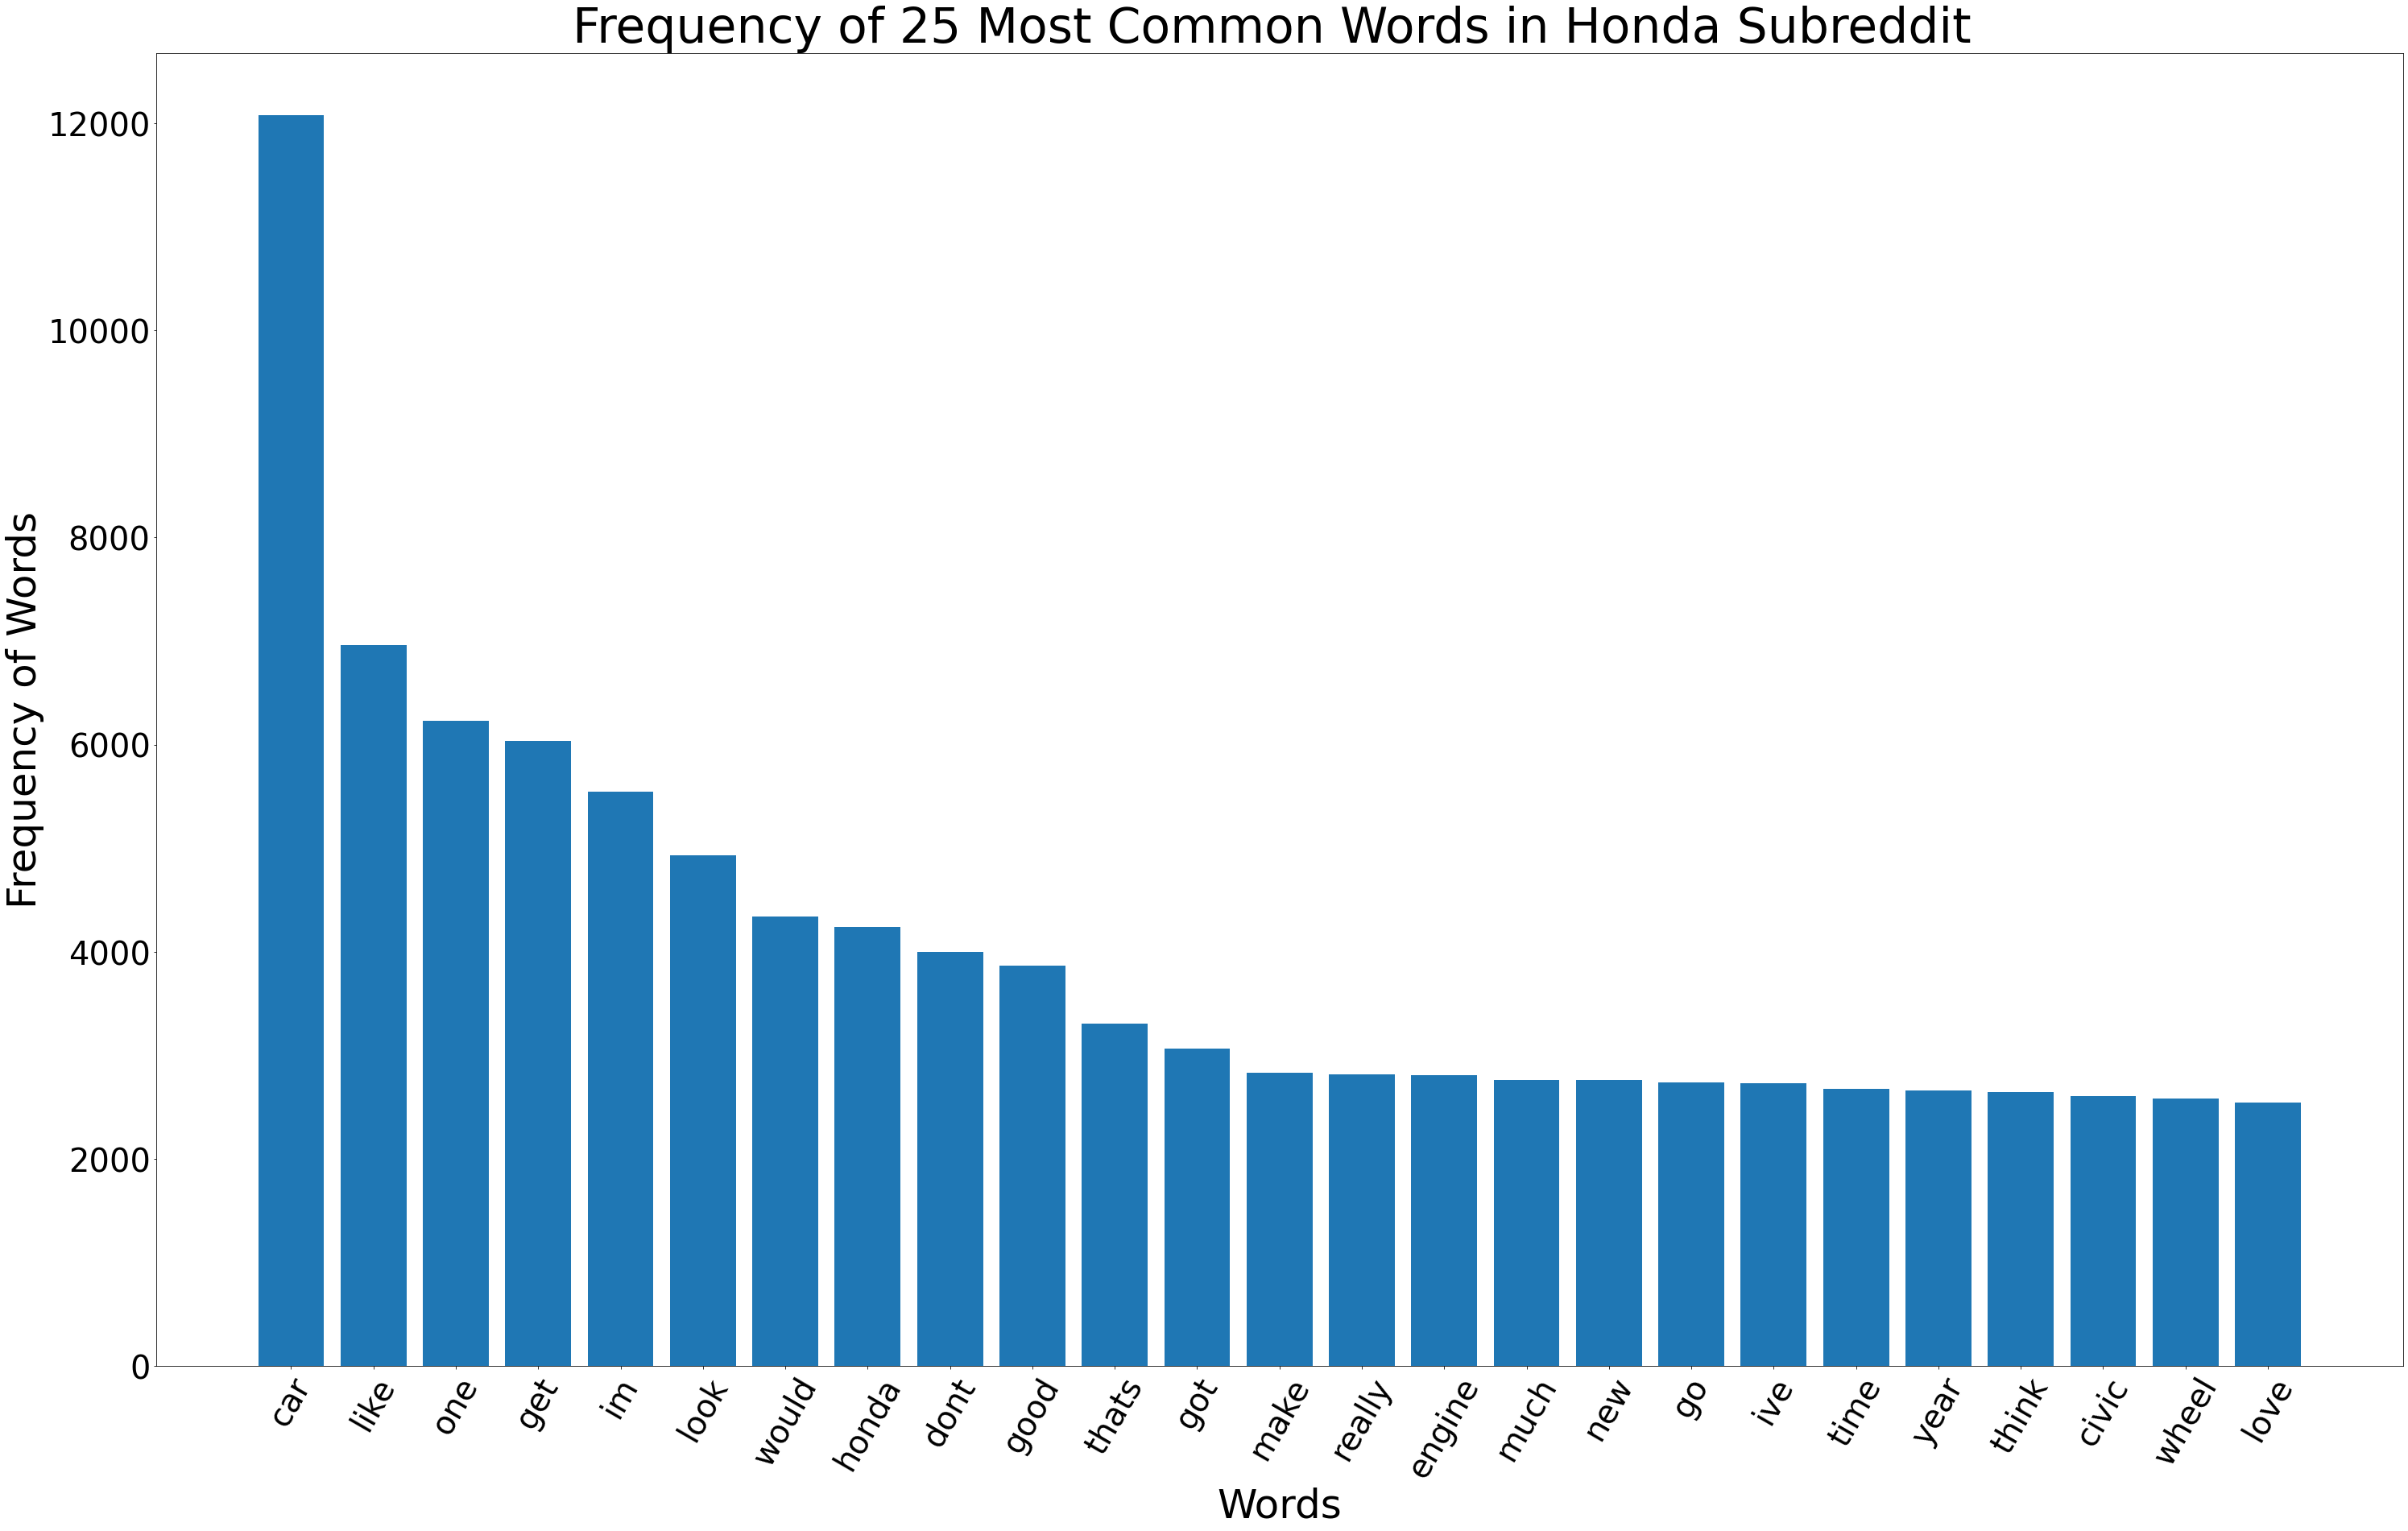

In [7]:
## EDA
## Honda General common words

# This function tokenizes words in every comment, and puts that word into a list and then joins list items to make one big list
words = honda_df['honda_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

# Function from NLTK that counts the frequency of words in the all words list and then gets the most common 25 words
mostcommon_small = FreqDist(allwords).most_common(25)

# Seperates dictionary keys (words) and values (counts) into x and y values for graphing
x ,y = zip(*mostcommon_small)

# Plot bar chart
plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Honda Subreddit ', fontsize=60);

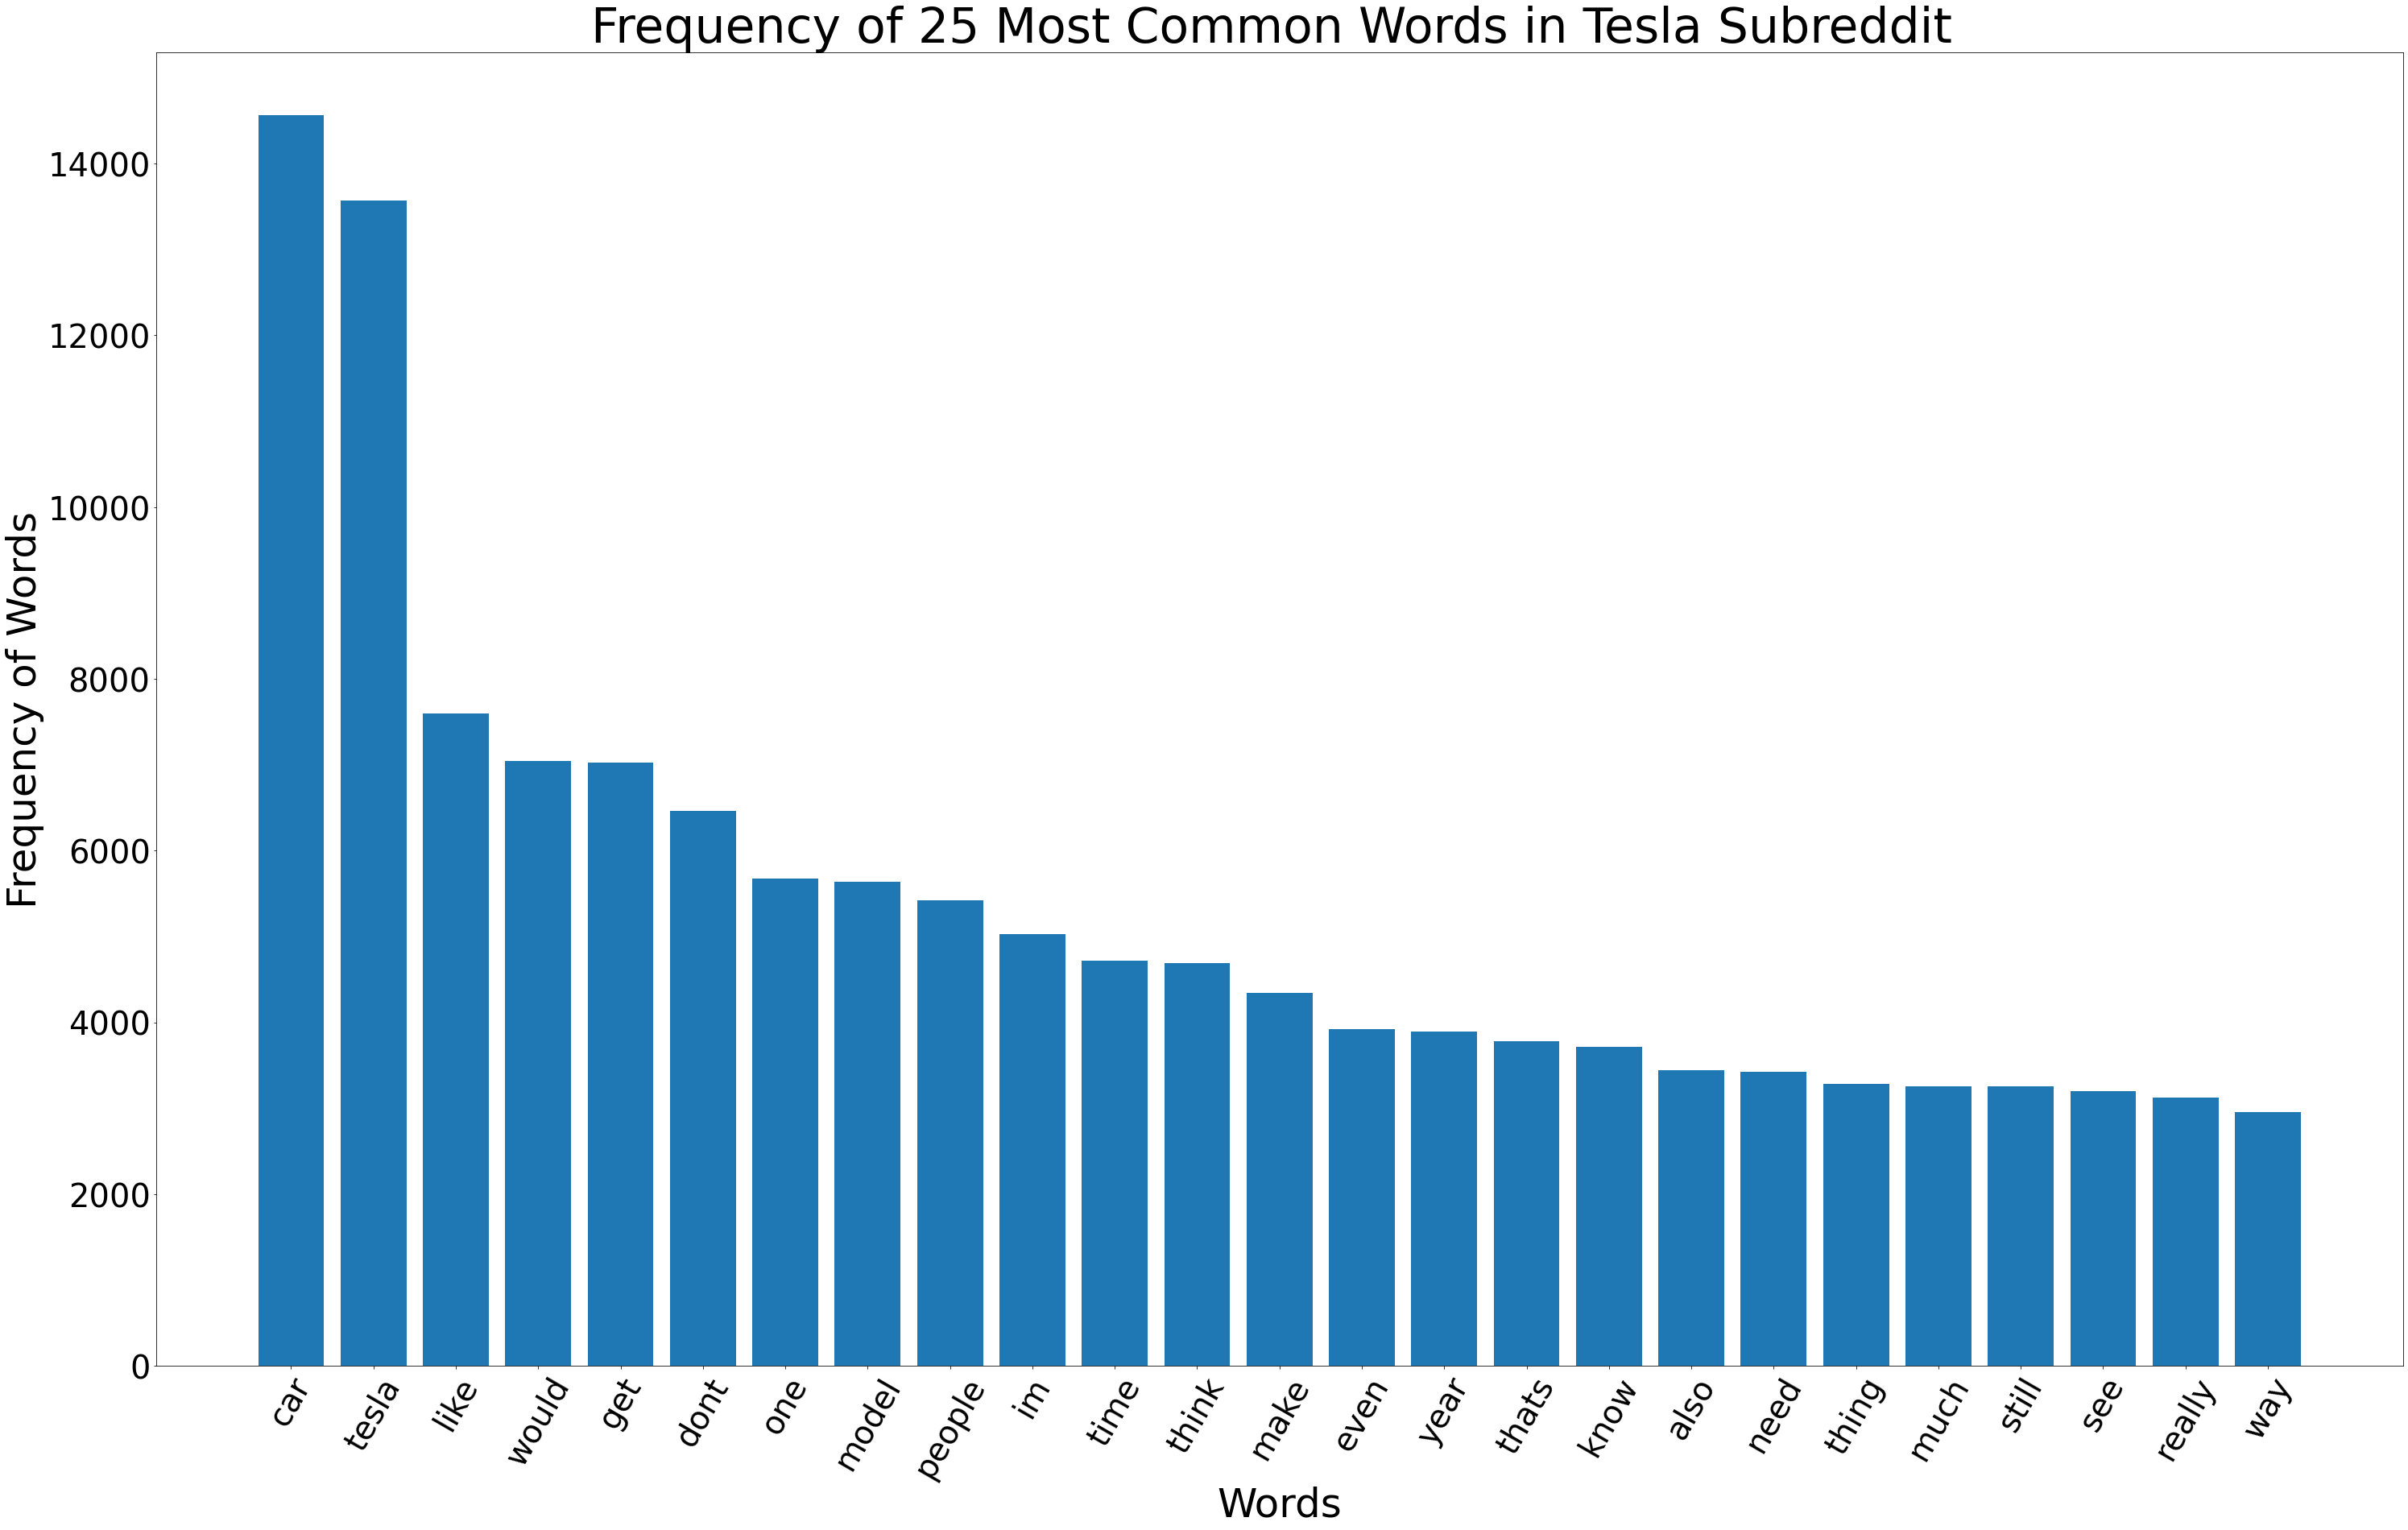

In [8]:
## Tesla General common words the same as Honda


words = tesla_df['tesla_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Tesla Subreddit ', fontsize=60);

In [9]:
## Sentiment analysis 
# First uses Lambda function with textblob to get sentiment score for every comment and only the seniment score value [0] and creates a DataFrame column for it
# Then sentiment categories are made with the sentiment column by taking <0 score as negative, 0 as neutral and >0 as positive and turning into a DataFrame column
tesla_df['sentiment'] = tesla_df['tesla_comments'].apply(lambda i: TextBlob(i).sentiment[0])
tesla_df['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in tesla_df['sentiment']]


honda_df['sentiment'] = honda_df['honda_comments'].apply(lambda i: TextBlob(i).sentiment[0])
honda_df['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in honda_df['sentiment']]

In [10]:
tesla_df

year                                     tesla_comments  sentiment  \
0      2018                                bear finish article   0.000000   
1      2018  really anger end people audacity pull youre re...   0.204762   
2      2018  android phone whatever reason seems iphones re...   0.000000   
3      2018  car covered bug moment hiding nasty chip winds...  -0.250463   
4      2018                              charge  need  breaker   0.000000   
...     ...                                                ...        ...   
57450  2022  thank lawyer going expensive feel obligated fi...  -0.066667   
57451  2022              mean guess better getting one warning   0.093750   
57452  2022                                     apple move tbh   0.000000   
57453  2022  gtyeah isnt moat lead moat implies preventing ...   0.142045   
57454  2022  bd use ai many time need say educare bit prepr...   0.175000   

      sentiment_category  
0                neutral  
1               positive  
2                neutral  
3               negative  
4                neutral  
...                  ...  
57450           negative  
57451           positive  
57452            neutral  
57453           positive  
57454           positive  

[54013 rows x 4 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


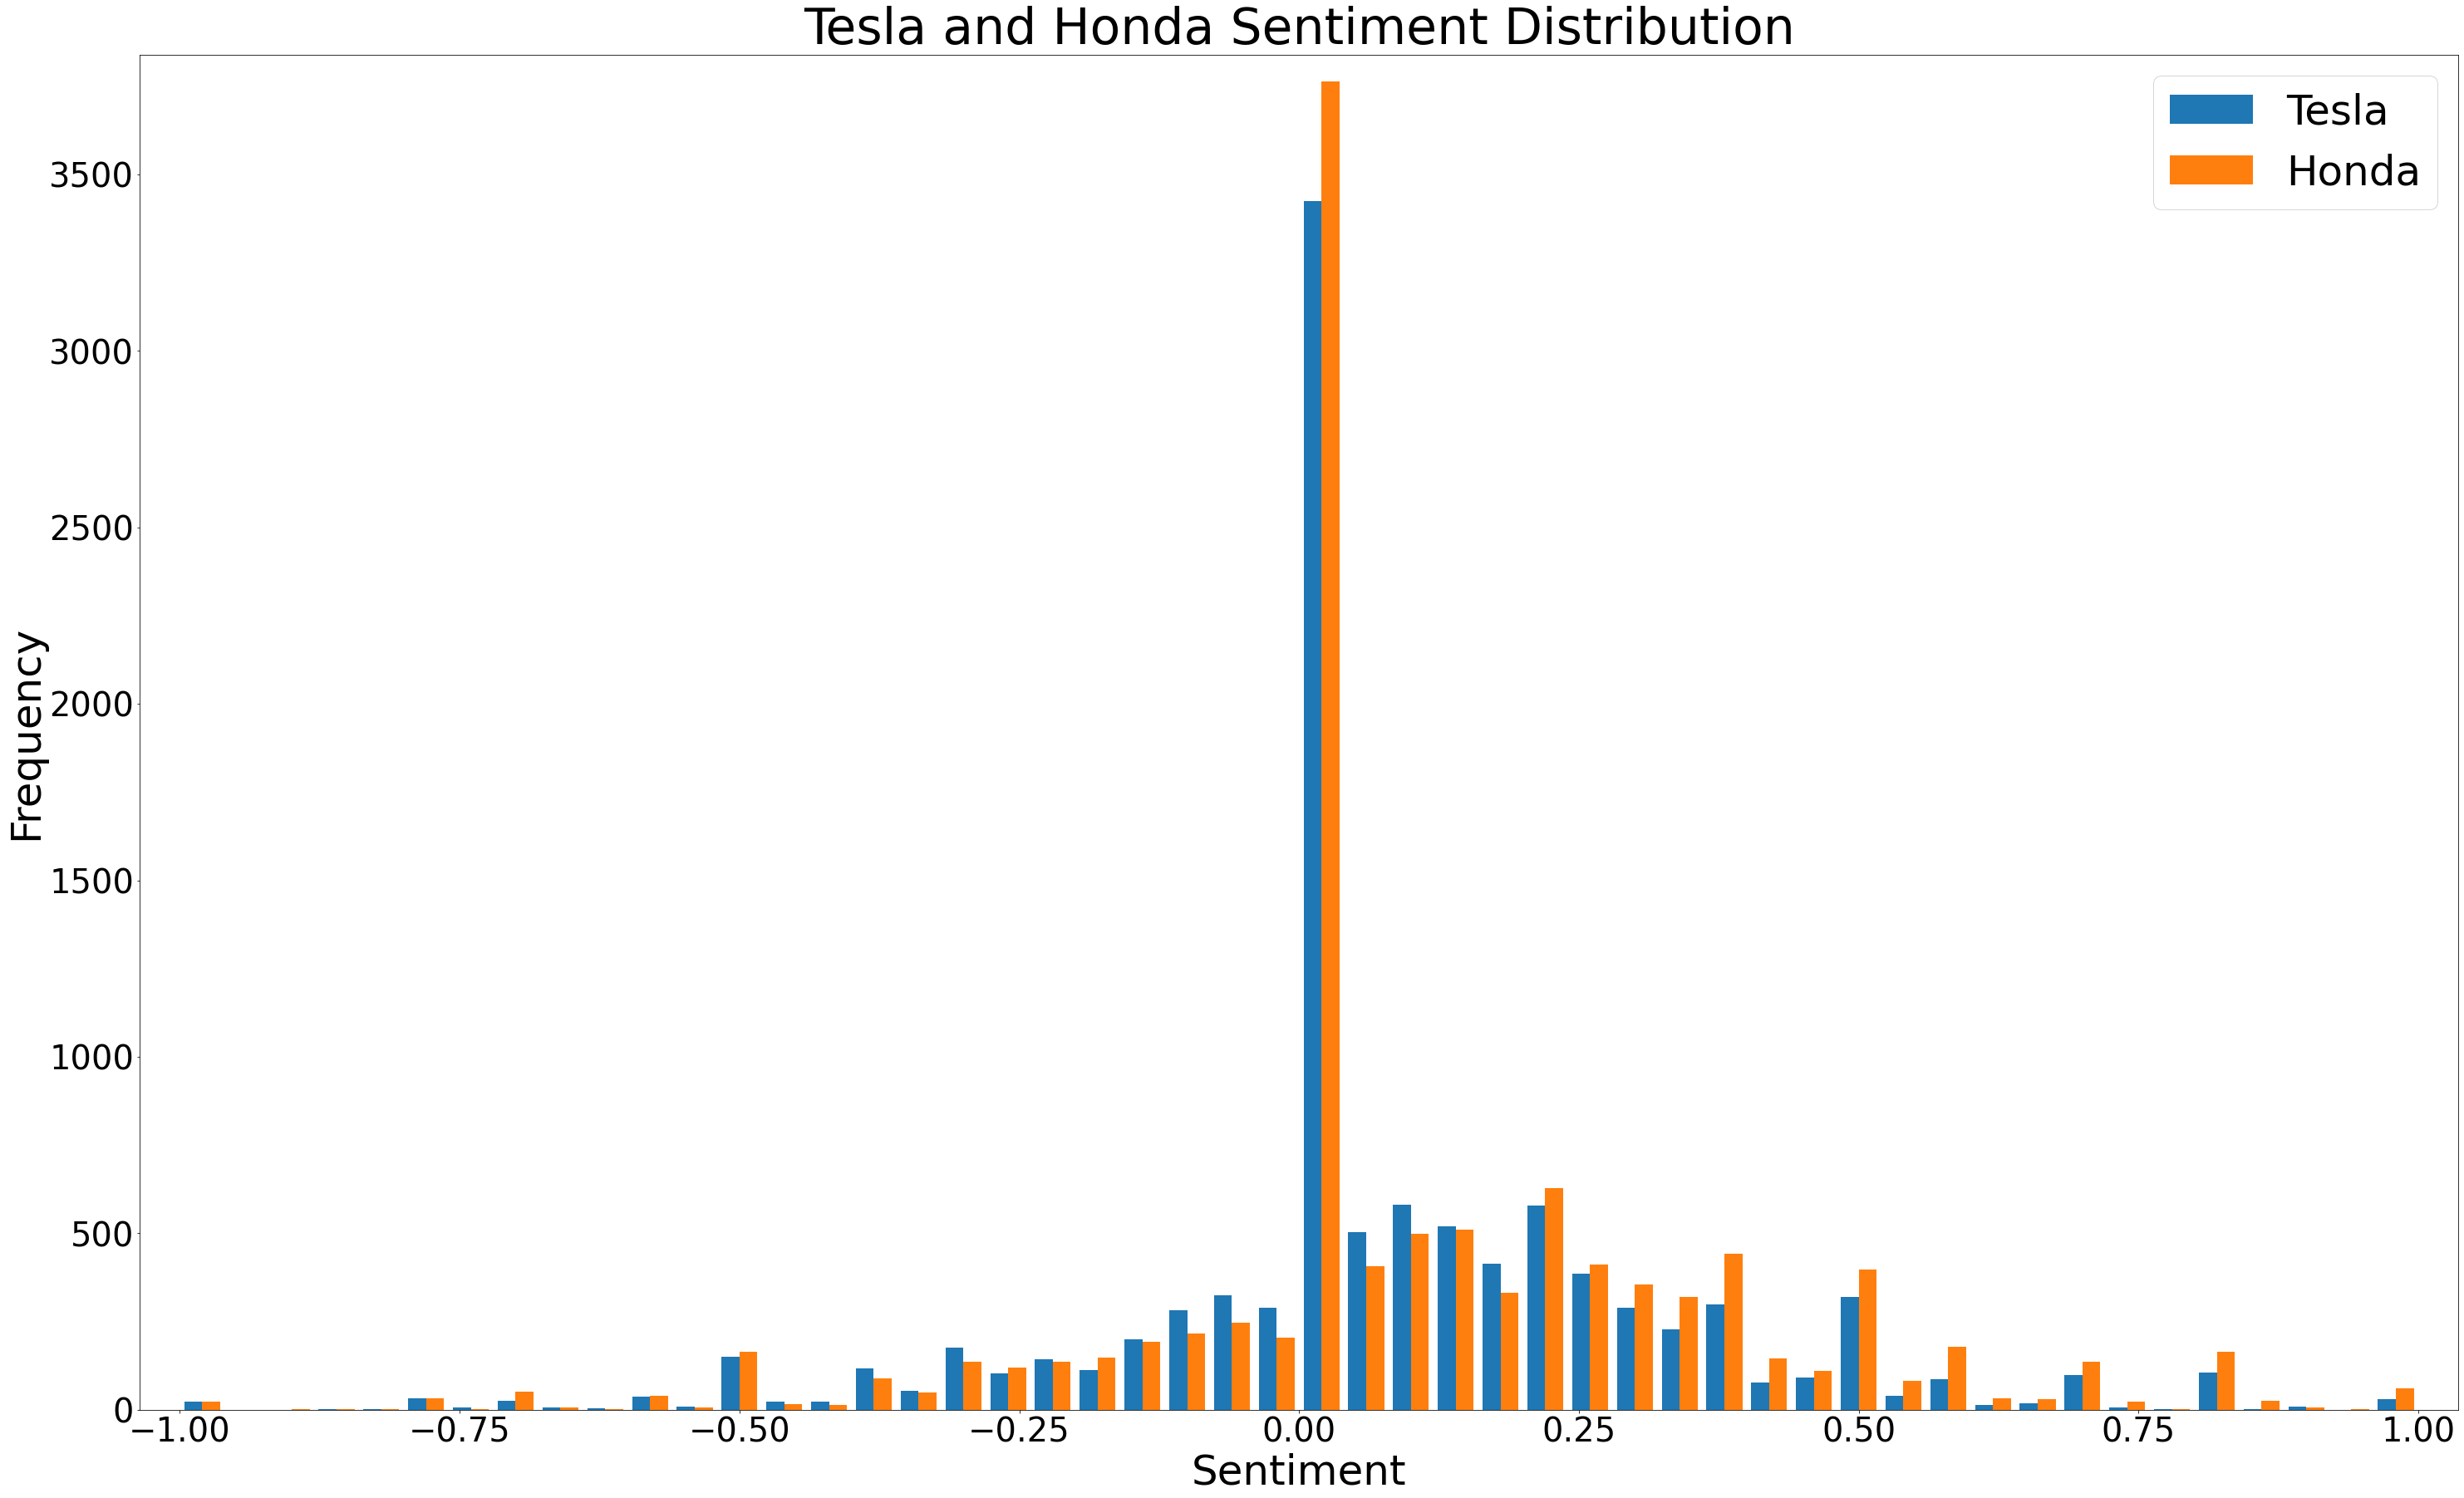

In [181]:
# gets only the 2022 data from both data sets
tesla_2022 = tesla_df[tesla_df['year'] == 2022]
honda_2022 = honda_df[honda_df['year'] == 2022]

# Uses these values to plot a grouped histogram to show the sentiment distributions of both Tesla and Honda subreddits
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.legend(loc="upper right")
plt.hist([tesla_2022['sentiment'],honda_2022['sentiment']], bins=50,label=['Tesla','Honda'])
plt.legend(loc="upper right",prop={'size': 50}) # This shows legend location and alters the size of the legend
plt.title('Tesla and Honda Sentiment Distribution', fontsize=60)
plt.show()

In [182]:
# Creates printout of the number of records for each category in the 2022 data
tesla_cats = tesla_df[tesla_df['year'] == 2022]['sentiment_category'].value_counts()

honda_cats = honda_df[honda_df['year'] == 2022]['sentiment_category'].value_counts()

positive    5035
neutral     3084
negative    2139
Name: sentiment_category, dtype: int64


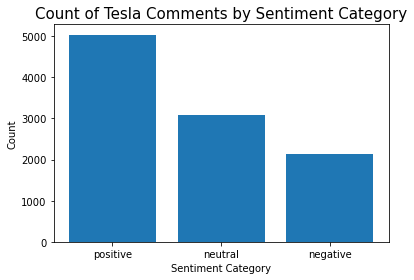

In [183]:
# Prints that printout
print(tesla_cats)

# Plots bar chart of values
plt.bar(tesla_cats.keys(),tesla_cats.values)

plt.title('Count of Tesla Comments by Sentiment Category', fontsize = 15)
plt.xlabel('Sentiment Category')
plt.ylabel('Count');

positive    5540
neutral     3521
negative    1899
Name: sentiment_category, dtype: int64


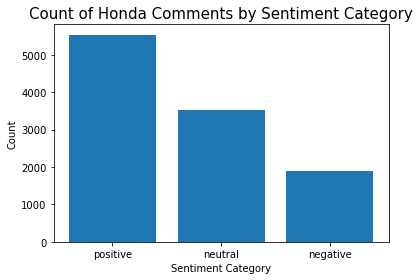

In [184]:
# Same process for Honda as above
print(honda_cats)

plt.bar(honda_cats.keys(),honda_cats.values)

plt.title('Count of Honda Comments by Sentiment Category', fontsize = 15)
plt.xlabel('Sentiment Category')
plt.ylabel('Count');

Tesla's mean of sentiment scores is:  0.07716348227173293

 Honda's mean of sentiment scores is:  0.11001539351256129


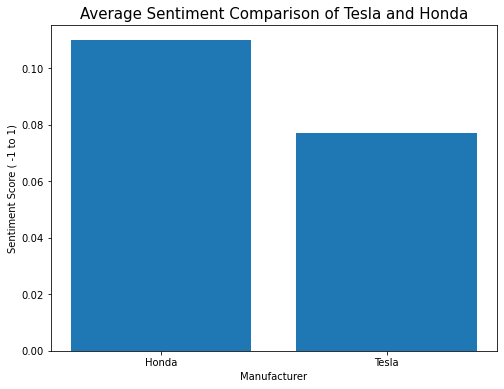

In [185]:
# Prints means of sentiment scores for both subreddits using the 2022 data
print( "Tesla's mean of sentiment scores is: ",tesla_df[tesla_df['year'] == 2022]['sentiment'].mean())
print("\n","Honda's mean of sentiment scores is: ",honda_df[honda_df['year'] == 2022]['sentiment'].mean())

# Creates bar chart comparison of means
plt.figure(figsize=(8,6))

plt.bar(['Honda', 'Tesla'],[honda_df[honda_df['year'] == 2022]['sentiment'].mean(),tesla_df[tesla_df['year'] == 2022]['sentiment'].mean()])

plt.title('Average Sentiment Comparison of Tesla and Honda', fontsize = 15)
plt.xlabel('Manufacturer')
plt.ylabel('Sentiment Score ( -1 to 1)');

In [186]:
# Creates hypothesis test for Mann-Whitney U test 
stat, p = mannwhitneyu(honda_df[honda_df['year'] == 2022]['sentiment'], tesla_df[tesla_df['year'] == 2022]['sentiment'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the test
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=59778230.500, p=0.000
Different distribution (reject H0)


In [187]:
# Prints p value seperately because Hypothesis test only shows it as 0
print ('p=',p)

p= 4.742877798868163e-16


In [188]:
## Creates seperate Dataframes for each sentiment category for both subreddit data in order to make seperate graphs for each one
positive_tesla_df = tesla_df[(tesla_df['sentiment_category'] == 'positive') & (tesla_df['year'] == 2022)]
neutral_tesla_df = tesla_df[(tesla_df['sentiment_category'] == 'neutral') & (tesla_df['year'] == 2022)]
negative_tesla_df = tesla_df[(tesla_df['sentiment_category'] == 'negative') & (tesla_df['year'] == 2022)]


positive_honda_df = honda_df[(honda_df['sentiment_category'] == 'positive') & (honda_df['year'] == 2022)]
neutral_honda_df = honda_df[(honda_df['sentiment_category'] == 'neutral') & (honda_df['year'] == 2022)]
negative_honda_df = honda_df[(honda_df['sentiment_category'] == 'negative') & (honda_df['year'] == 2022)]


### Honda

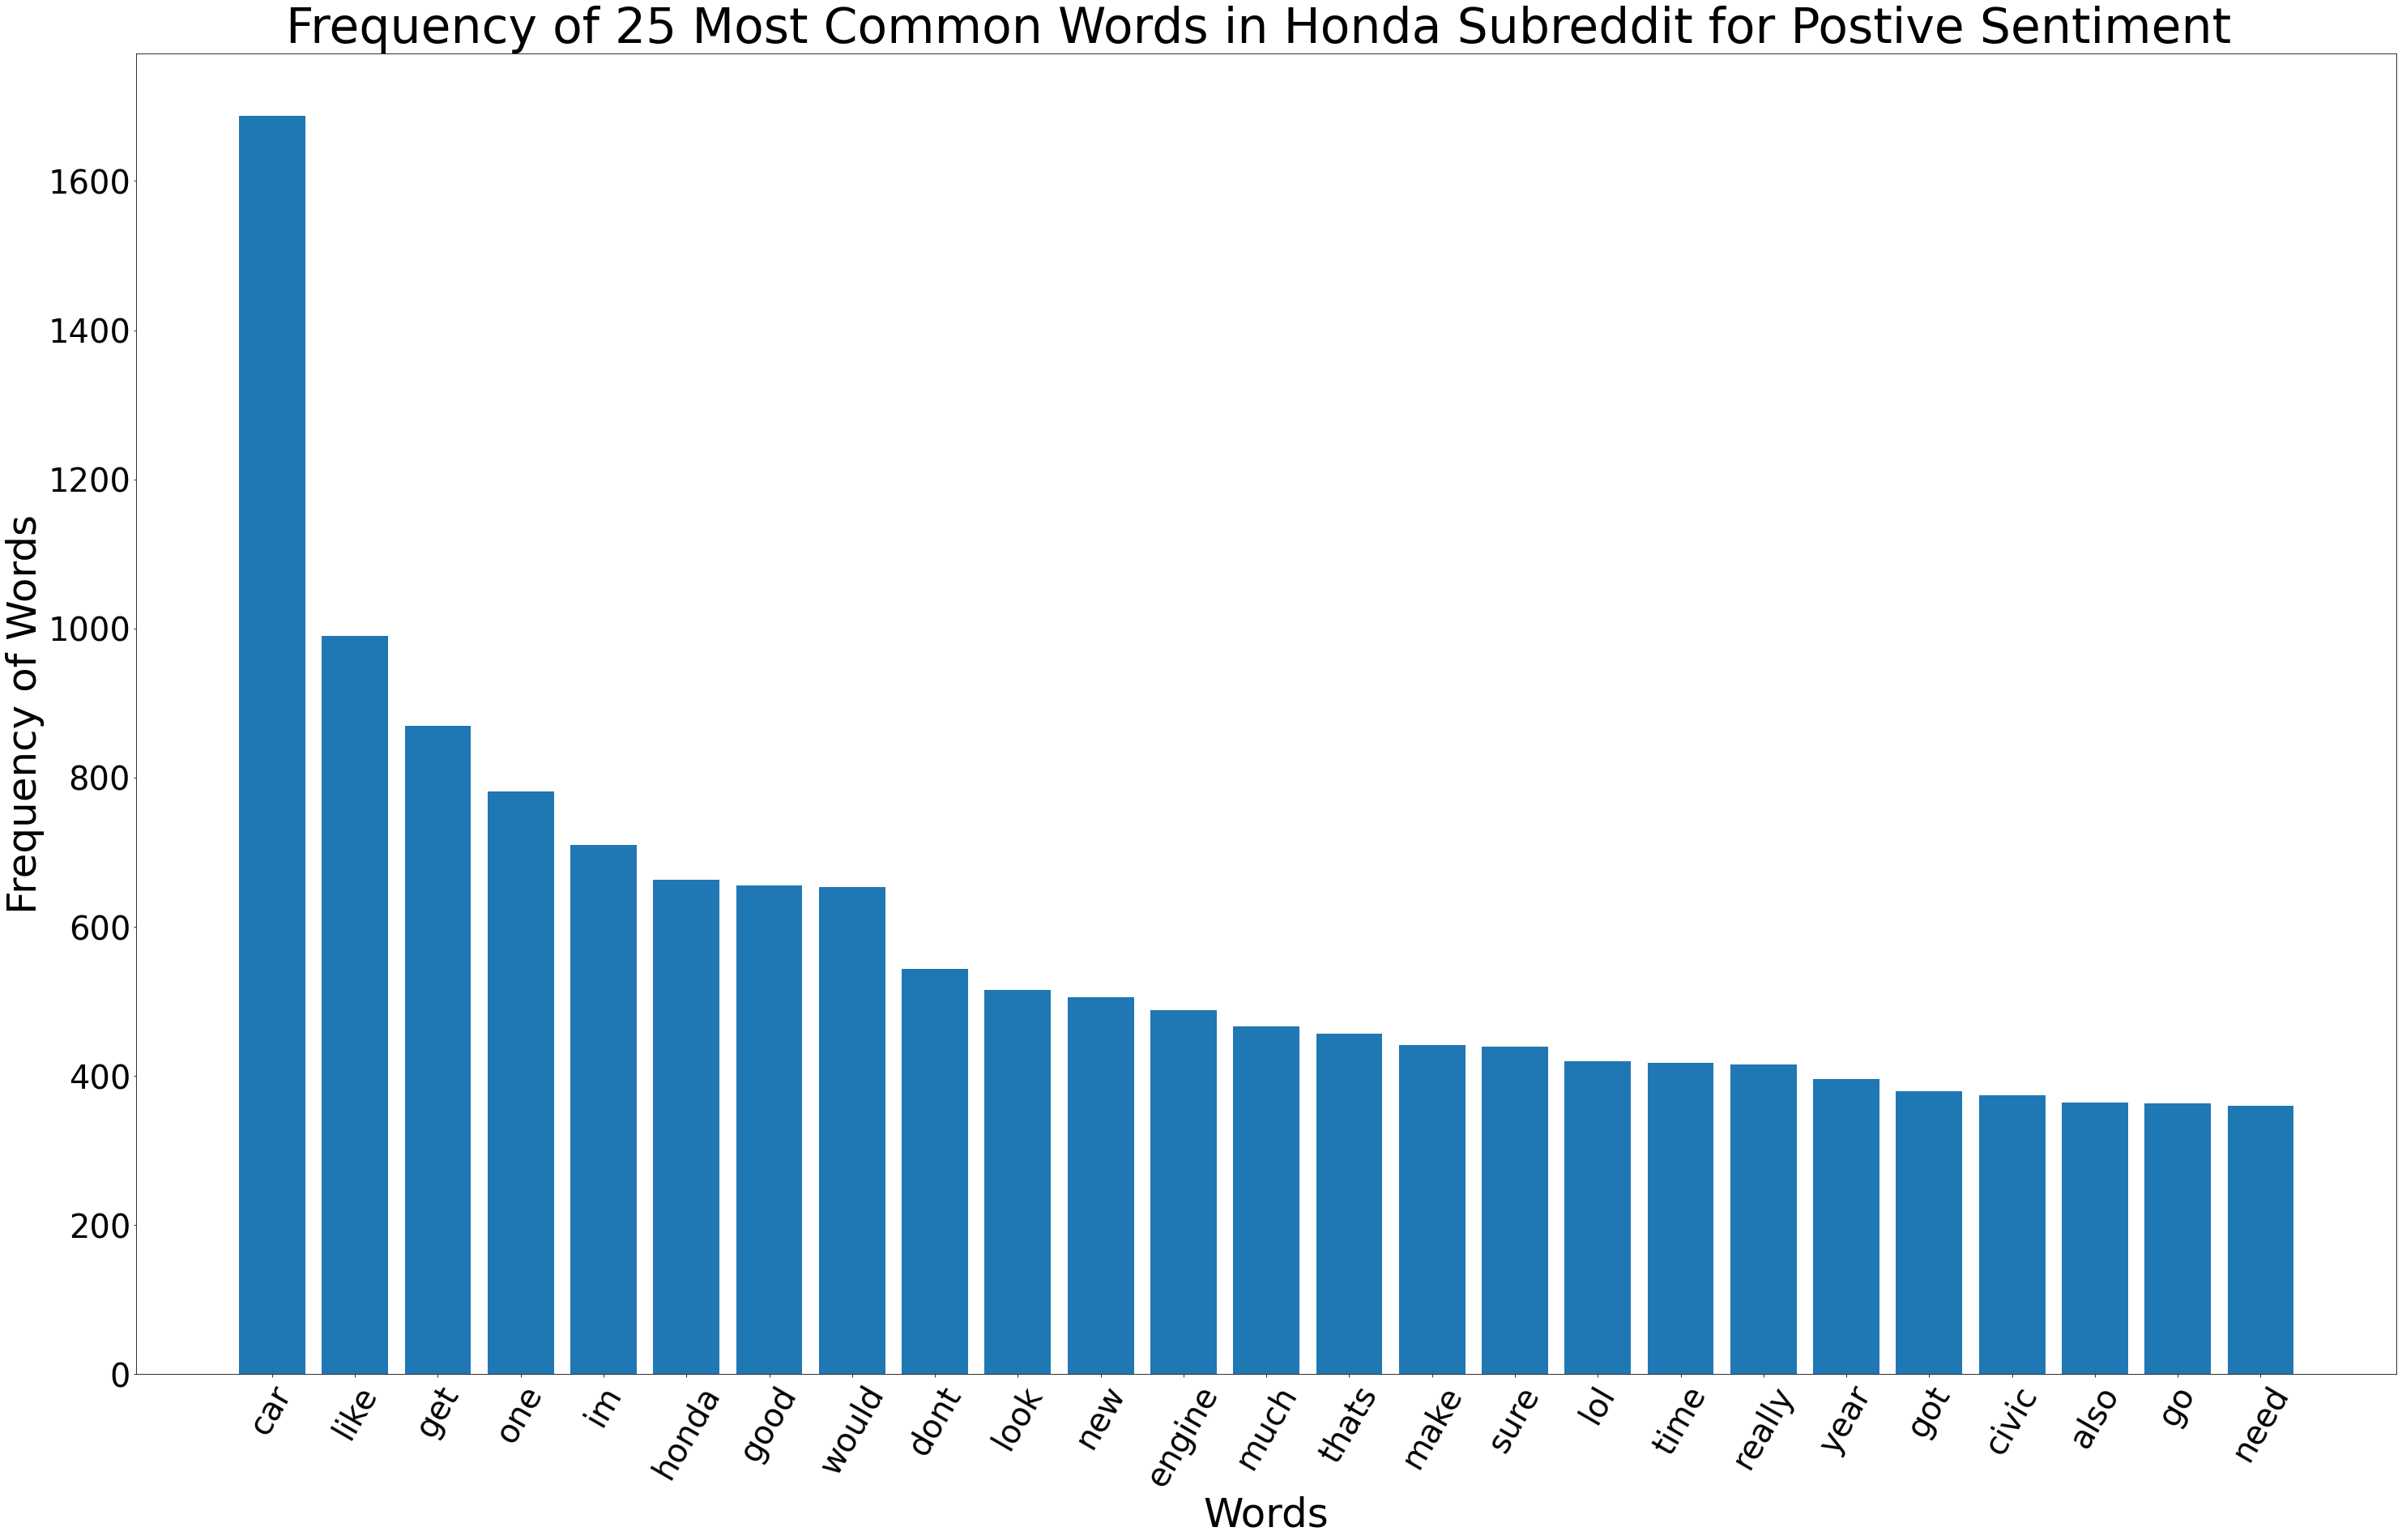

In [189]:
## For each subreddit and each sentiment cateogry a bar graph of the 25 most common words is made and 
## a word cloud chart for the 100 most common words is made
## the same code is done for every sentiment category
# Honda Postive

# First words are tokenized again and the lists are joined to create one big list
words = positive_honda_df[positive_honda_df['year'] == 2022]['honda_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

    # Function from NLTK that counts the frequency of words in the all words list and then gets the most common 25 words
mostcommon_small = FreqDist(allwords).most_common(25)

# Puts dictionary elements into x and y values again
x ,y = zip(*mostcommon_small)

# Plots bar chart
plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Honda Subreddit for Postive Sentiment ', fontsize=60);




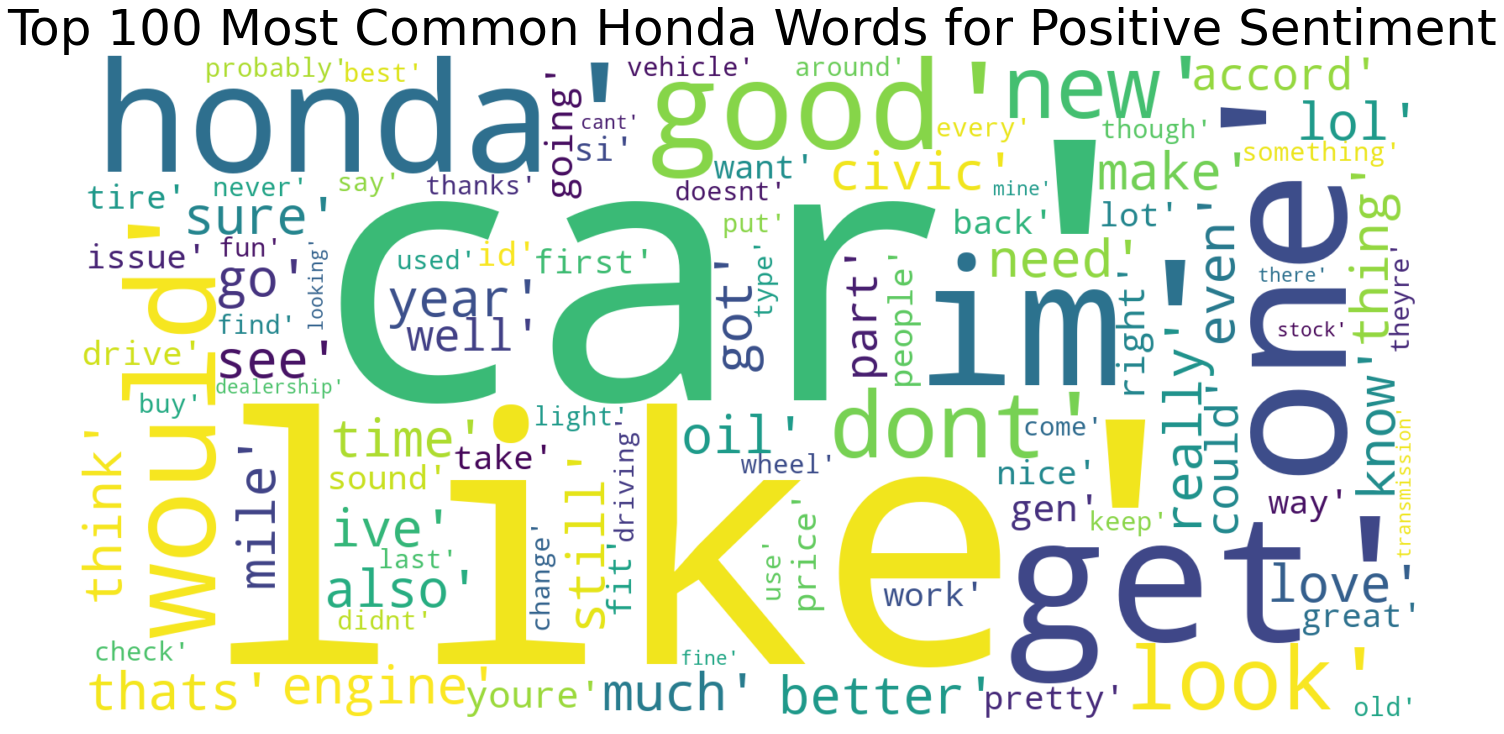

In [190]:
# Uses NLTK function to find 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
# Creates dimensions for word cloud and inputs 100 most common words data into the .generate function
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Honda Words for Positive Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

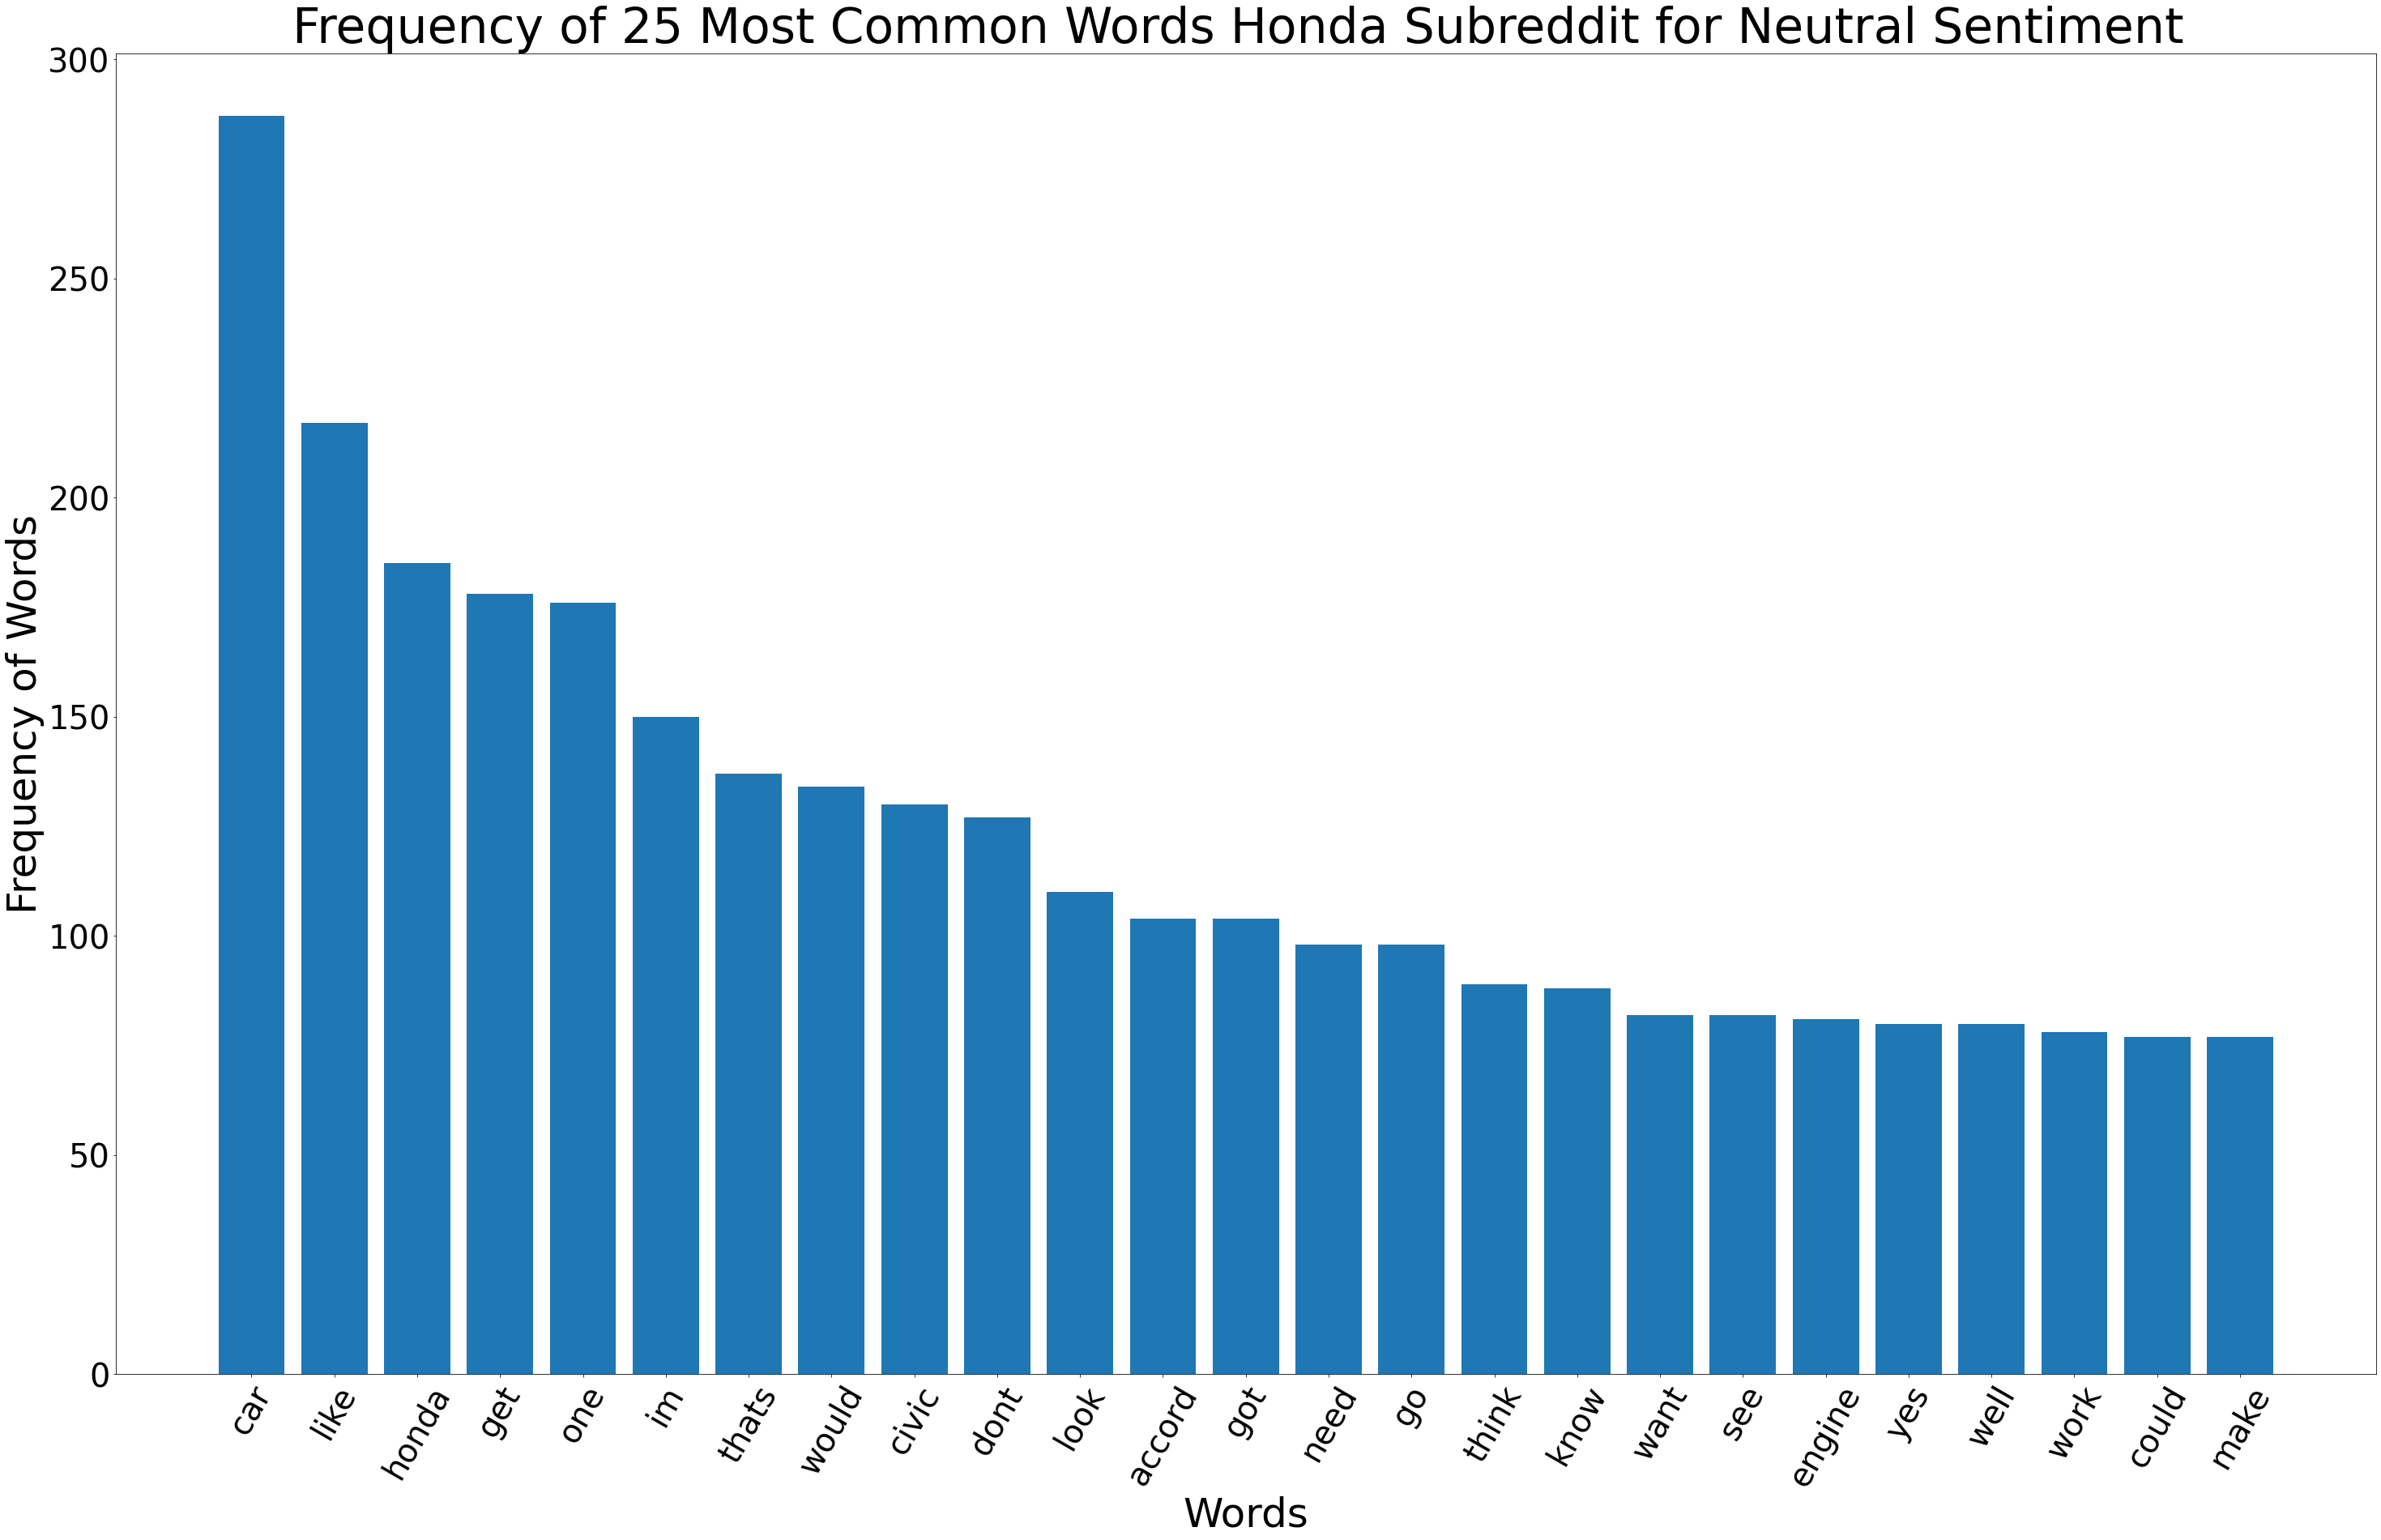

In [131]:
# Honda Neutral


words = neutral_honda_df[neutral_honda_df['year'] == 2022]['honda_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words Honda Subreddit for Neutral Sentiment ', fontsize=60);




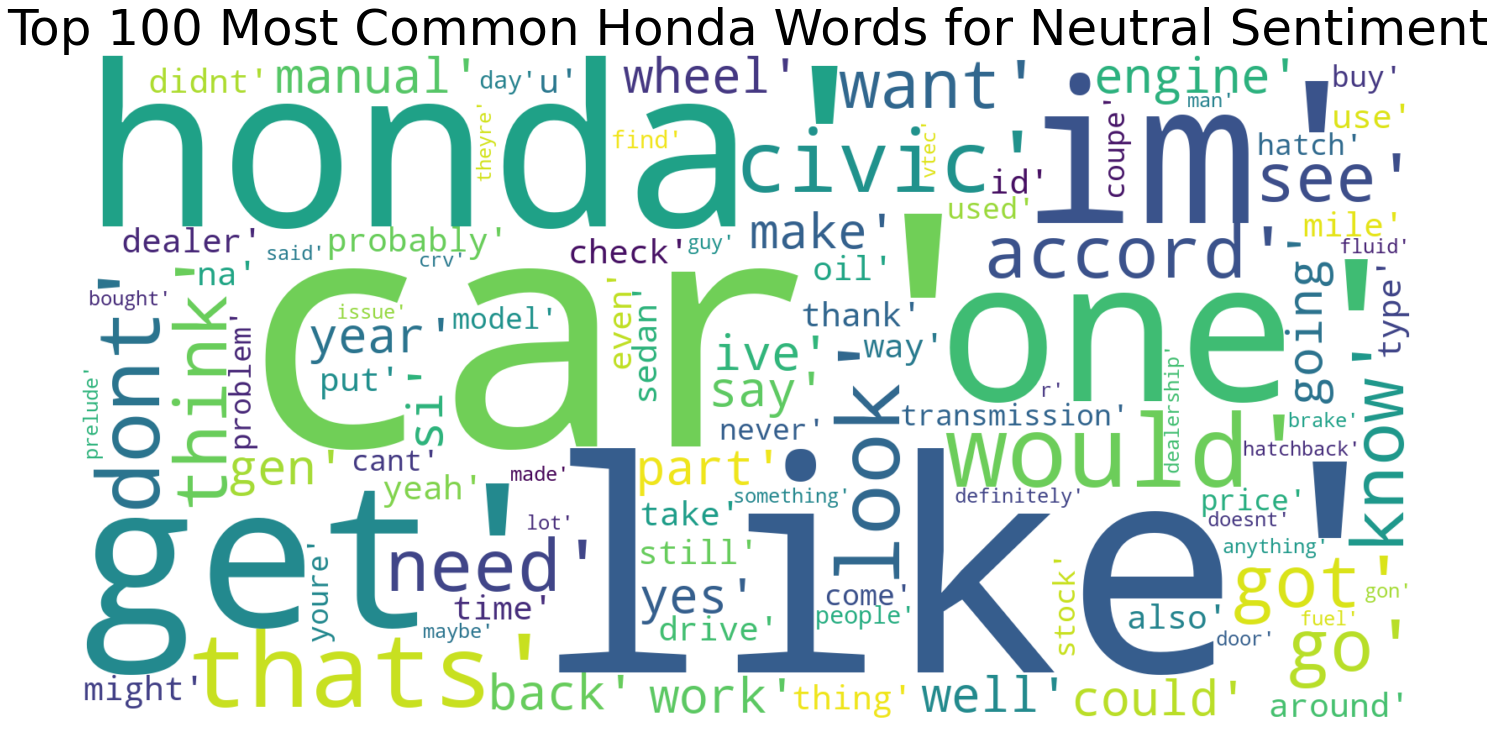

In [133]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Honda Words for Neutral Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

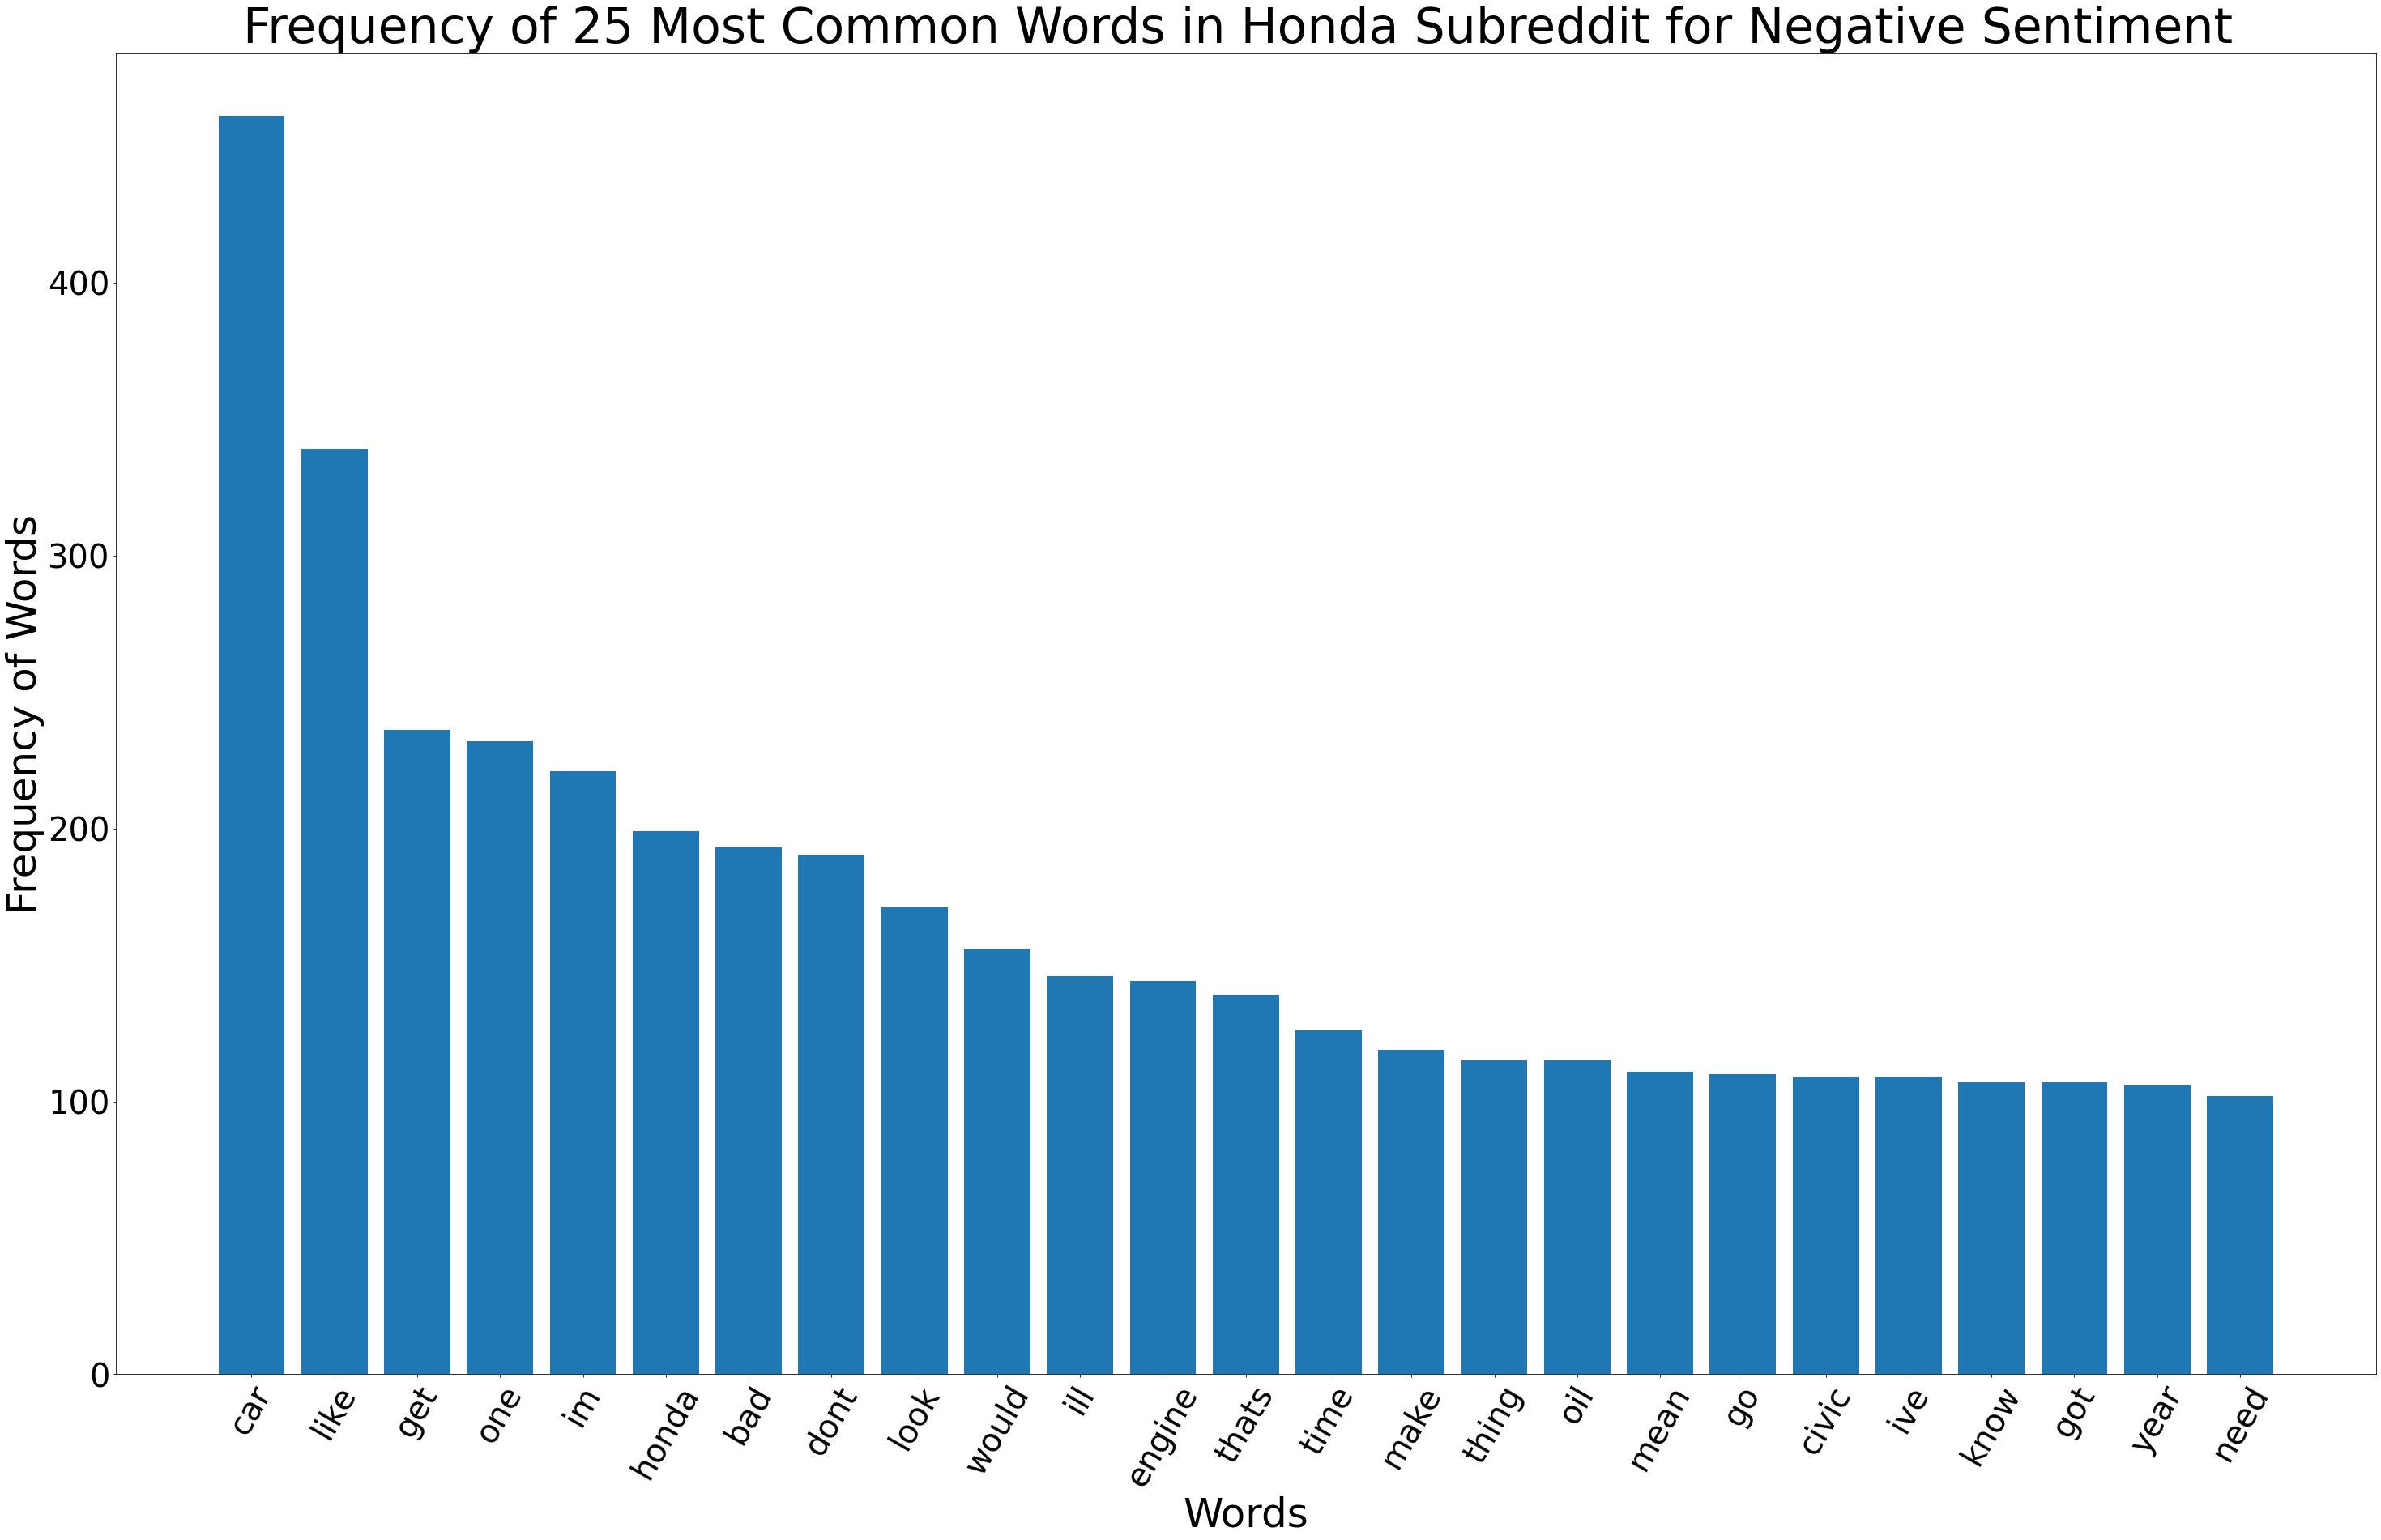

In [134]:
# Honda Negative


words = negative_honda_df[negative_honda_df['year'] == 2022]['honda_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Honda Subreddit for Negative Sentiment ', fontsize=60);




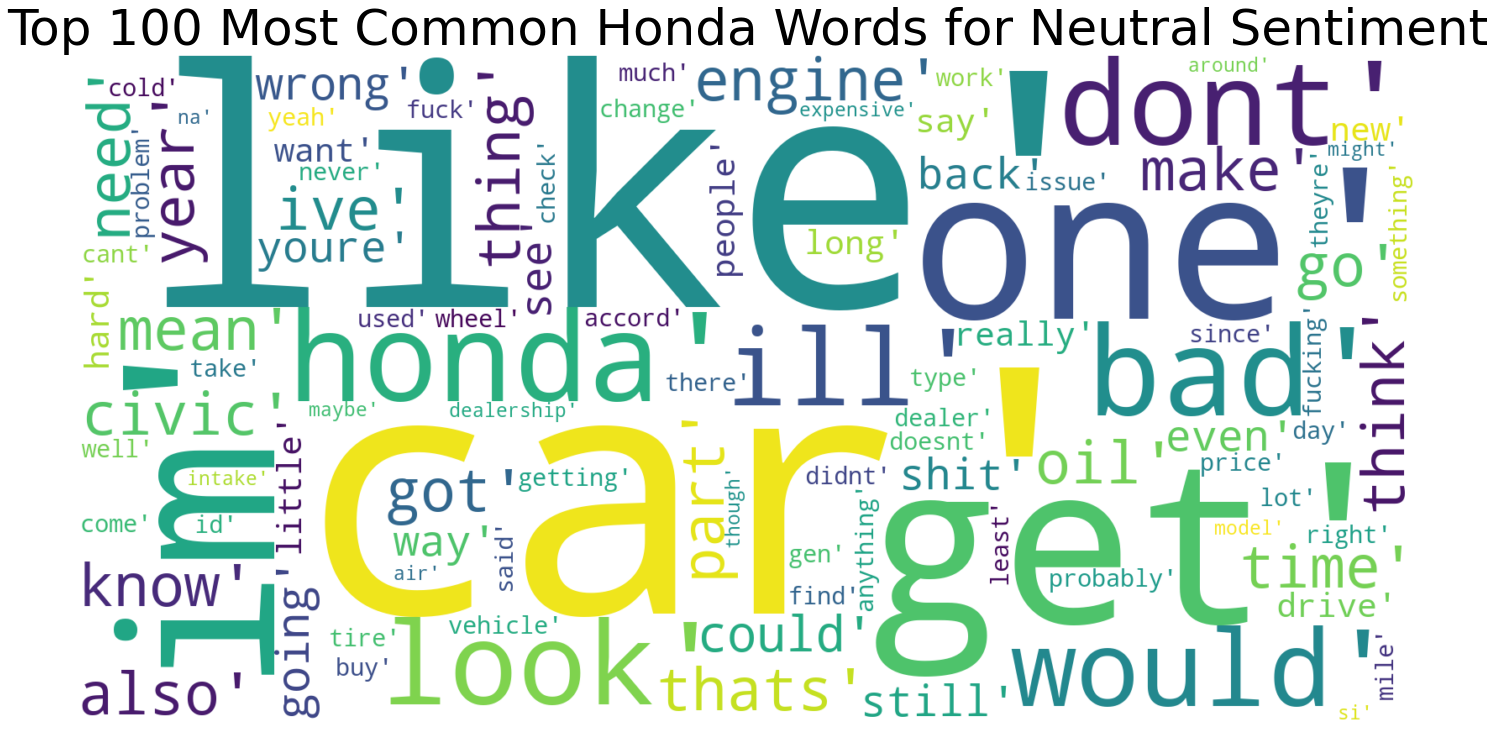

In [136]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Honda Words for Neutral Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

### Tesla

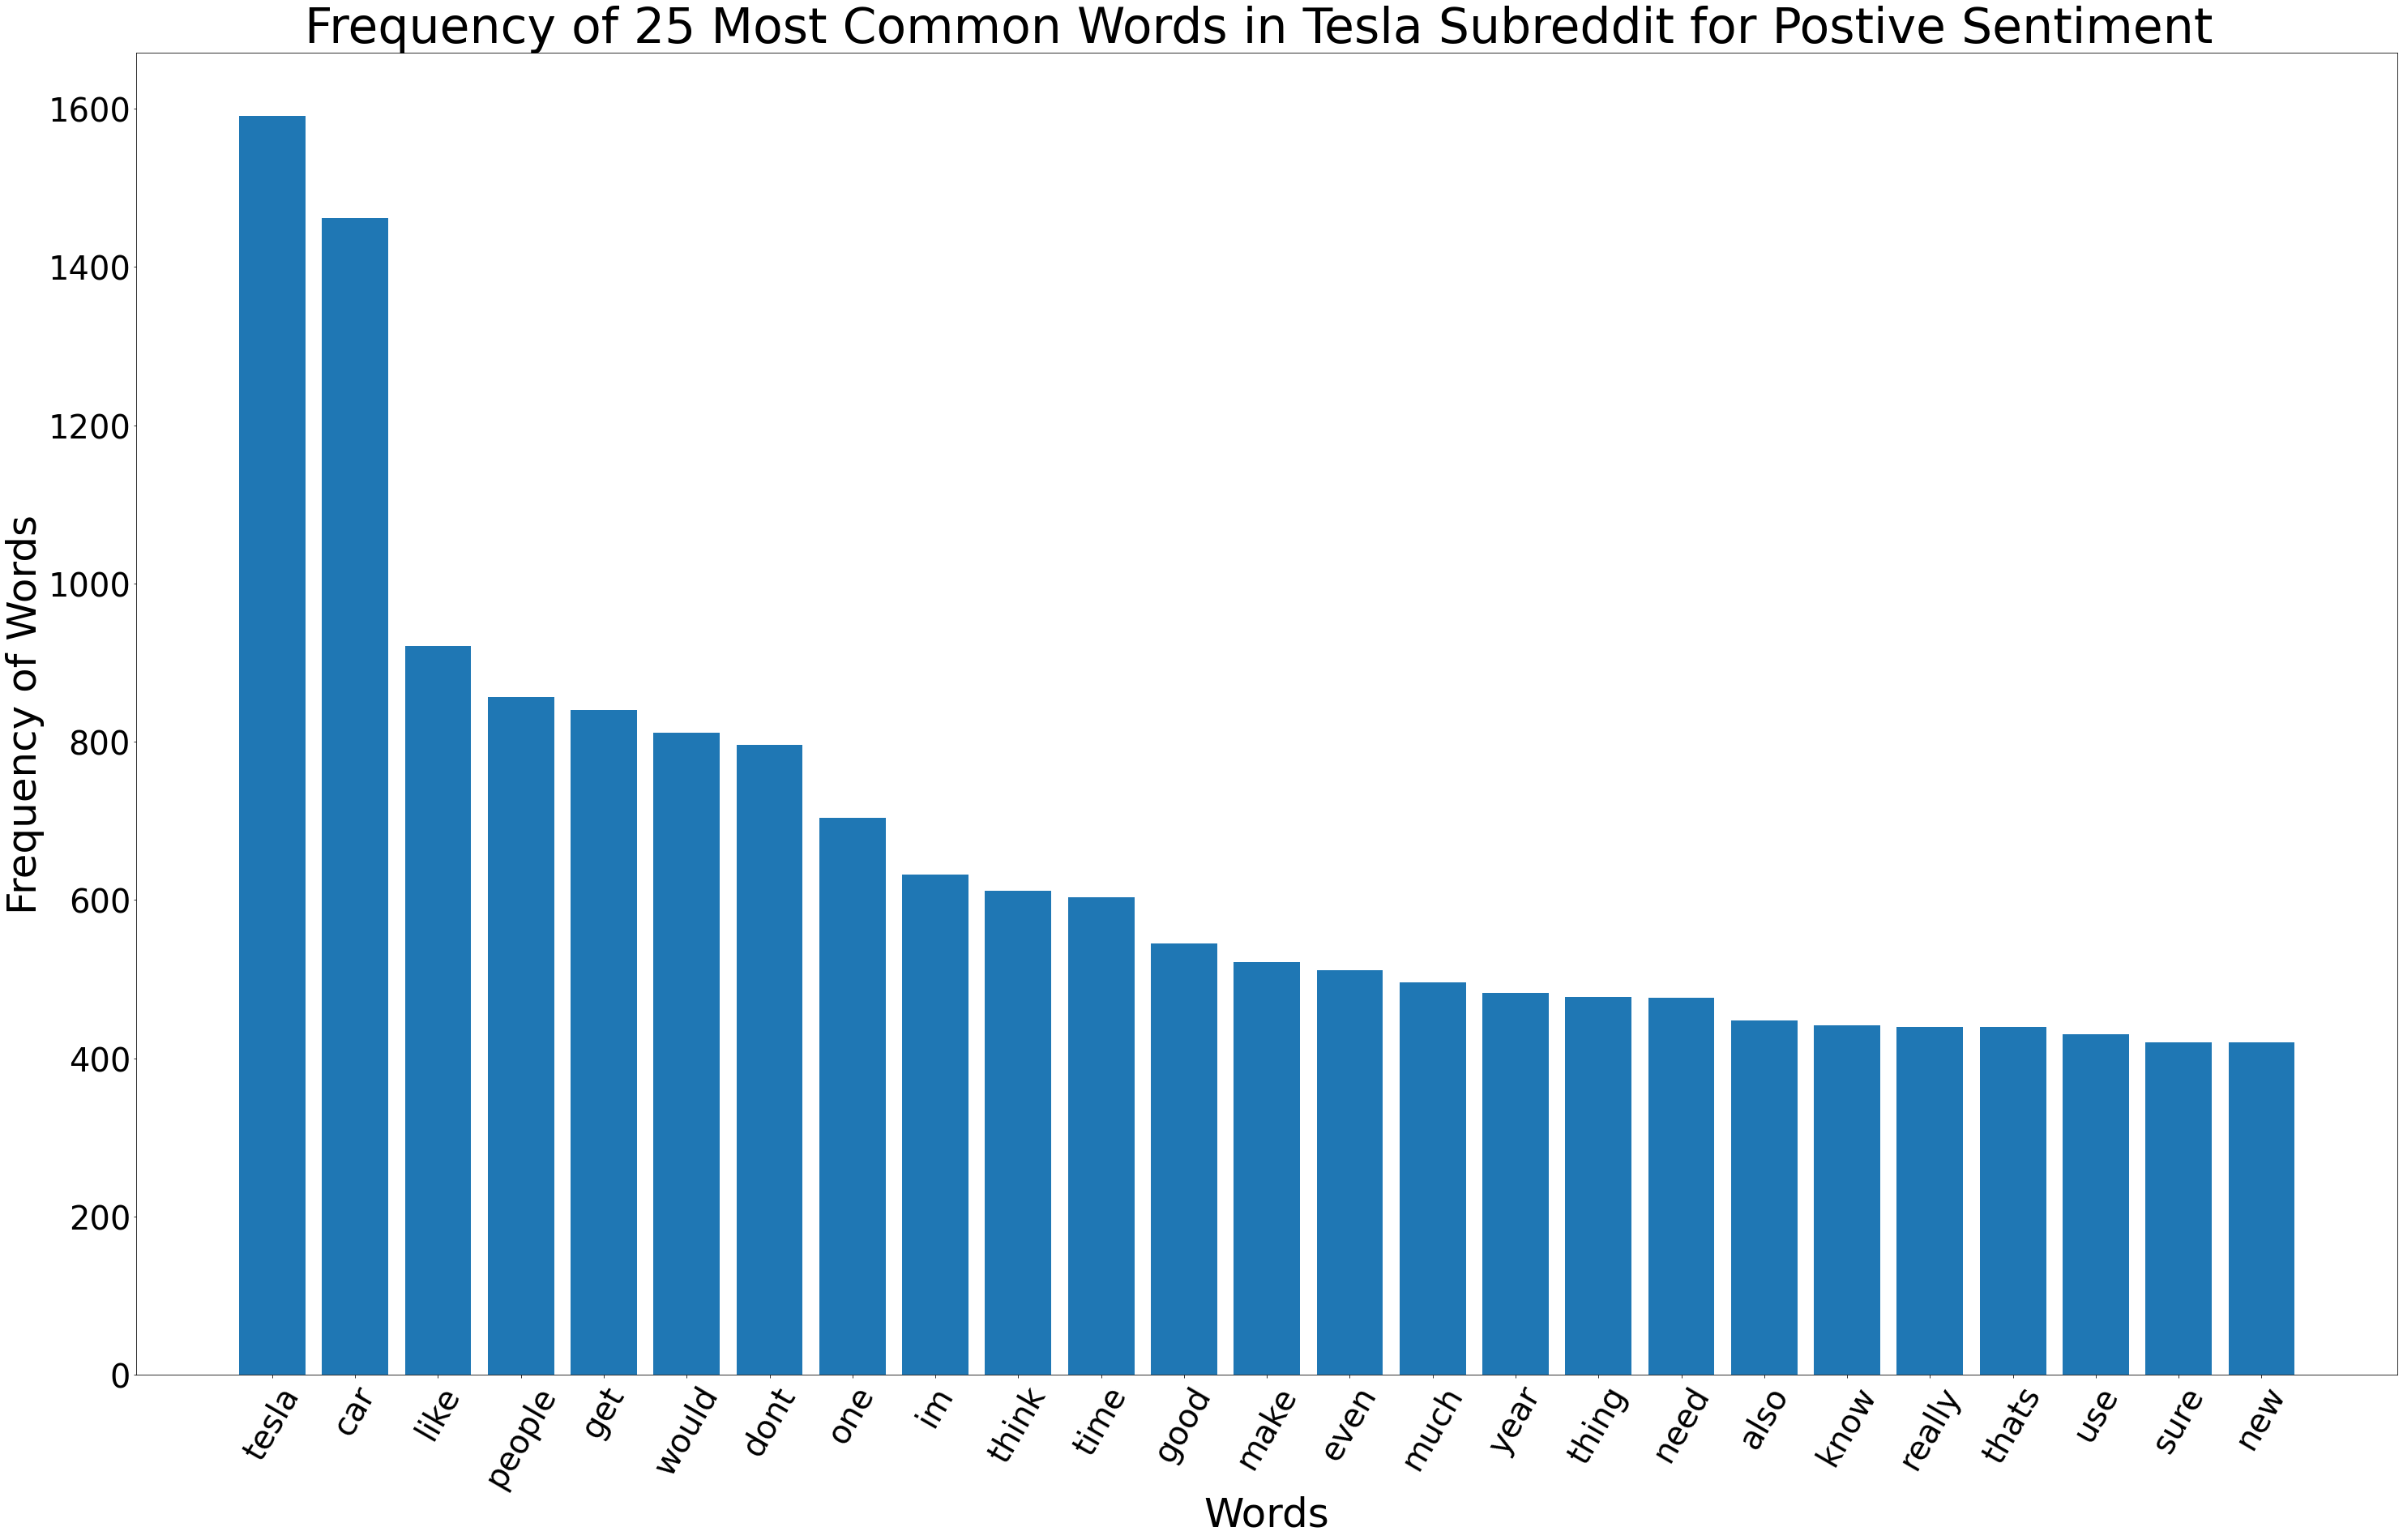

In [137]:
# Tesla Postive


words = positive_tesla_df[positive_tesla_df['year'] == 2022]['tesla_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Tesla Subreddit for Postive Sentiment ', fontsize=60);




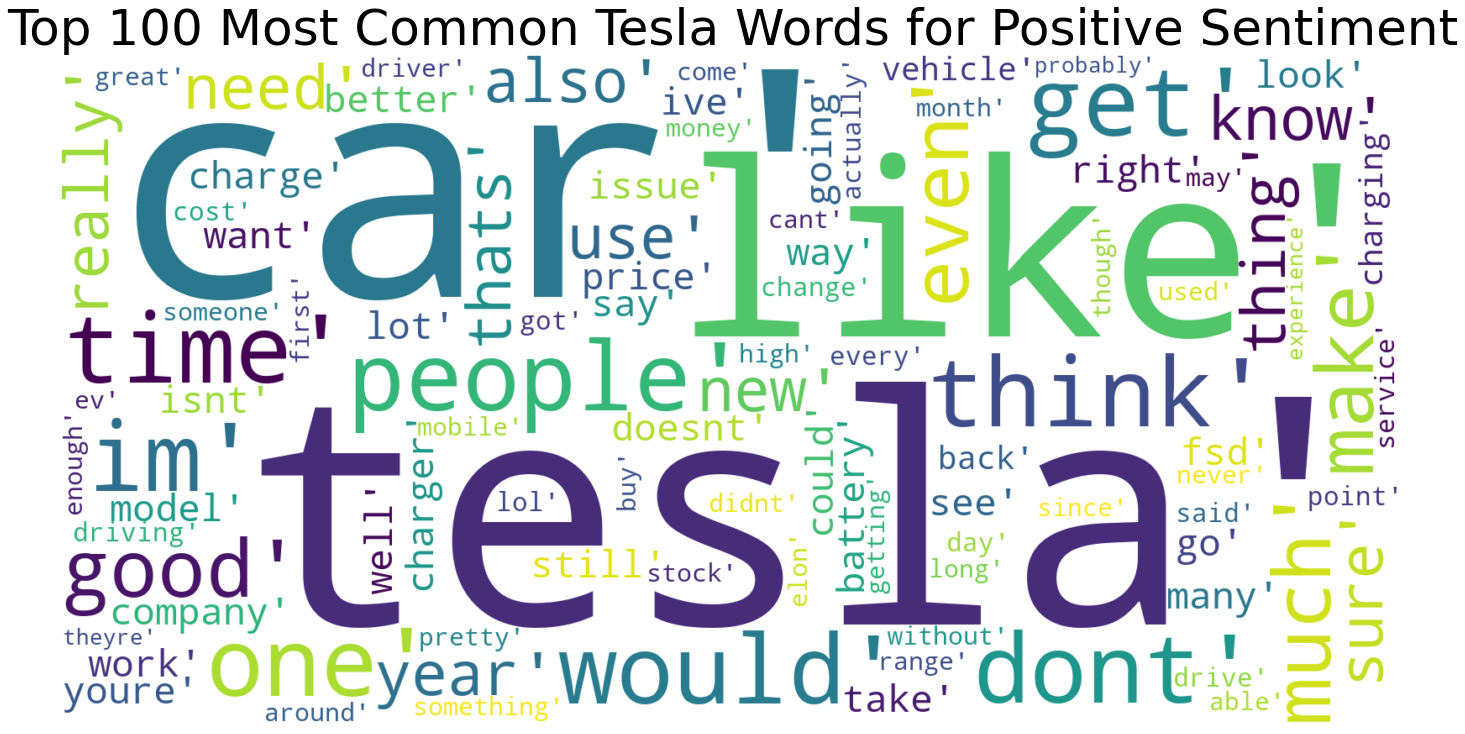

In [138]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Tesla Words for Positive Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

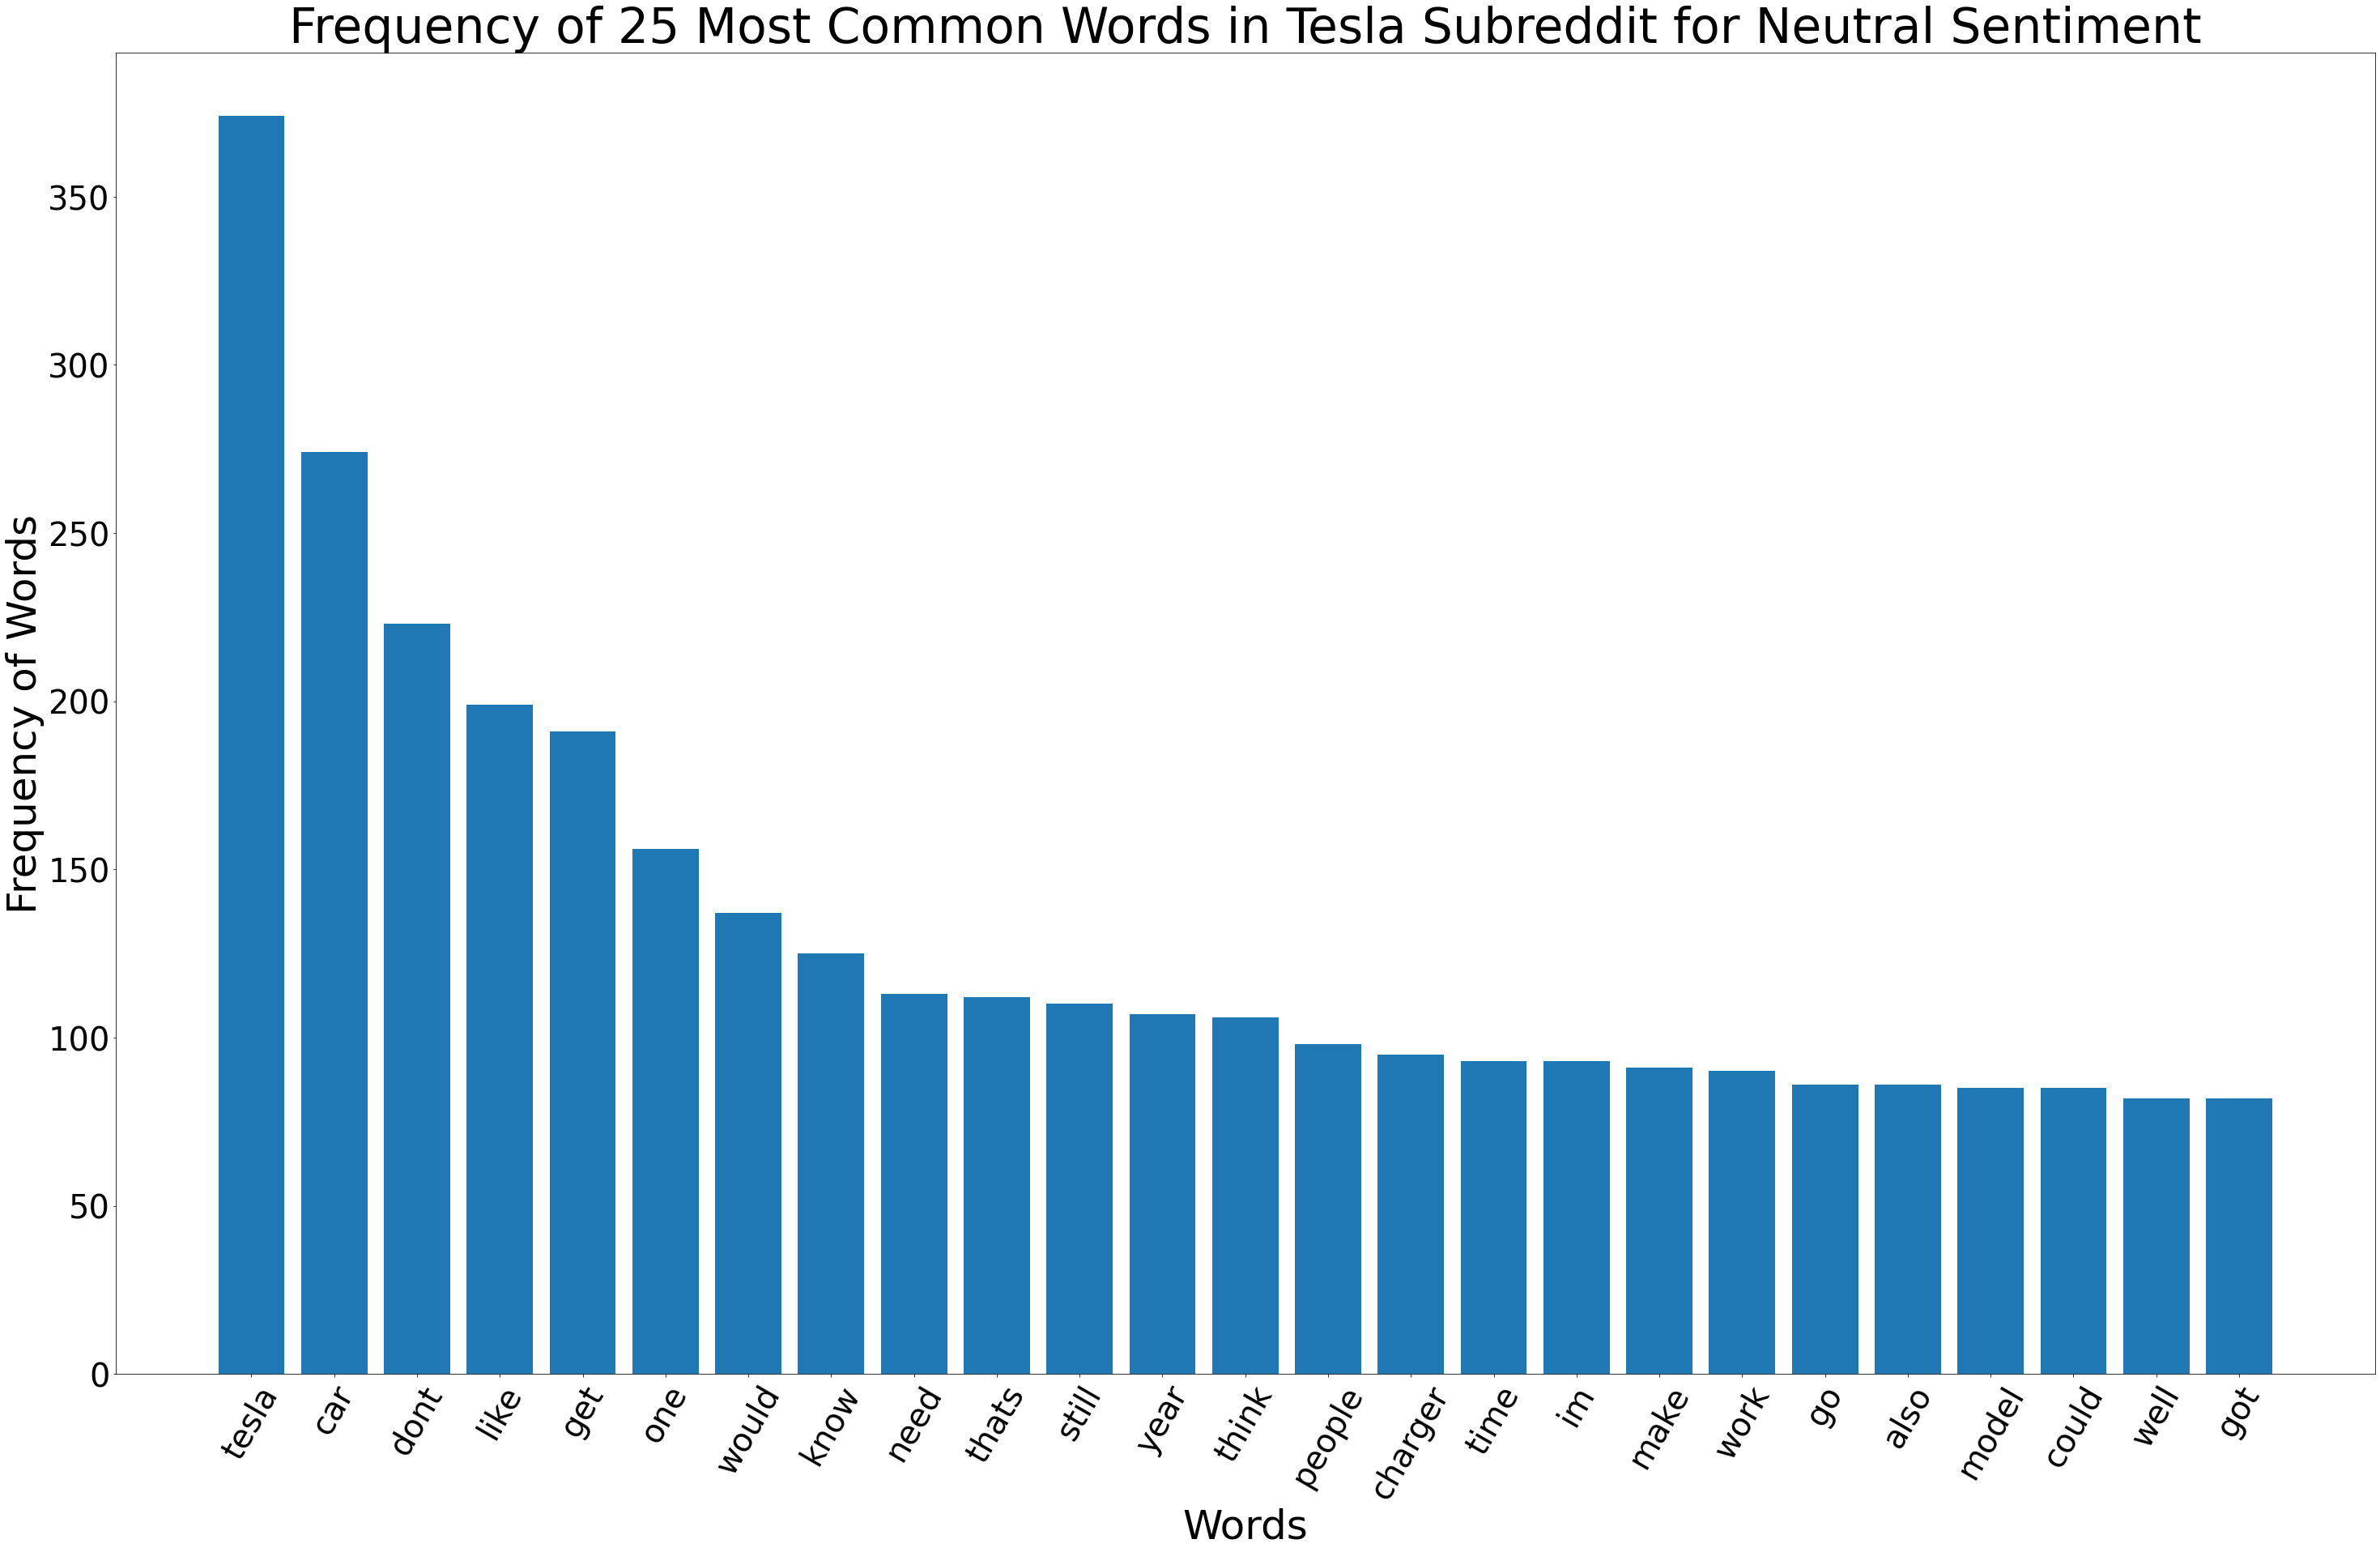

In [139]:
# Tesla neutral


words = neutral_tesla_df[neutral_tesla_df['year'] == 2022]['tesla_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Tesla Subreddit for Neutral Sentiment', fontsize=60);




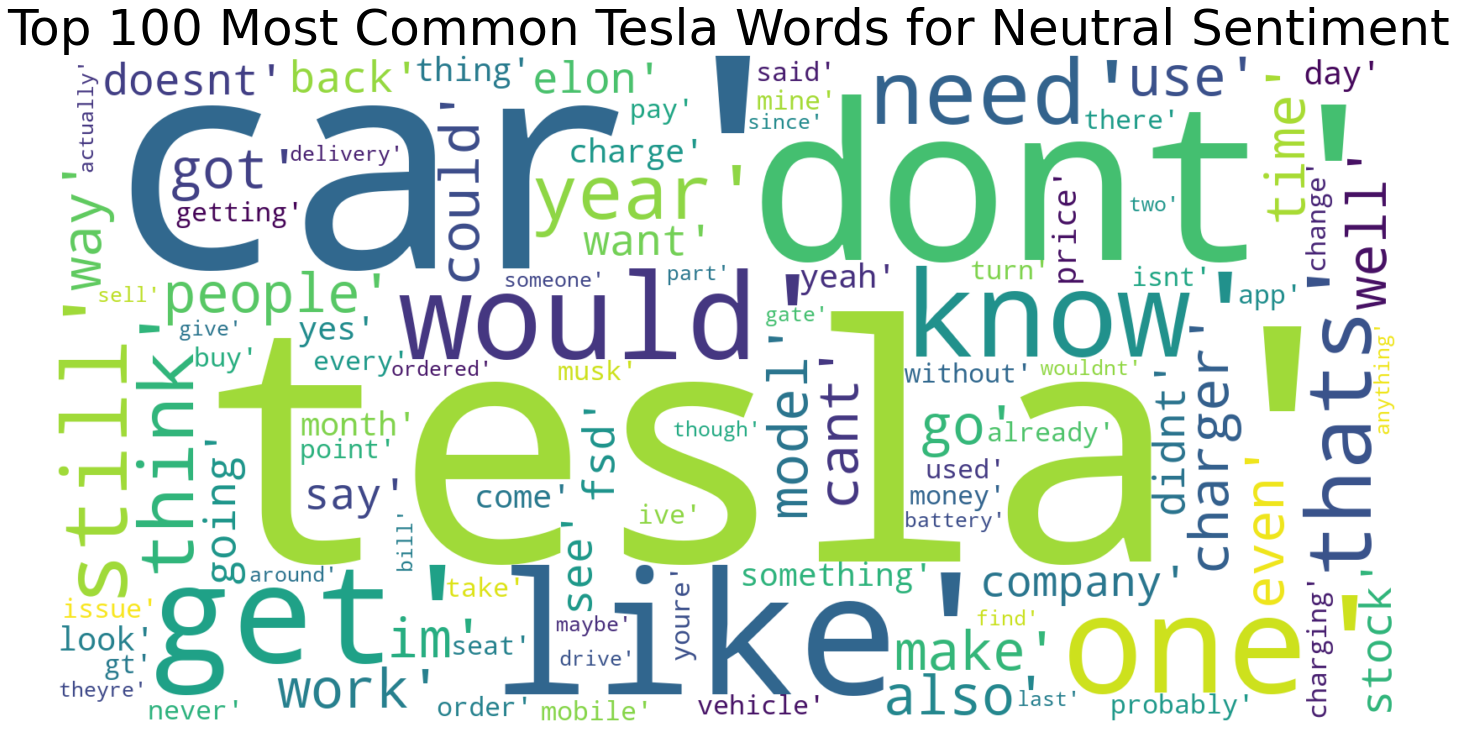

In [140]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Tesla Words for Neutral Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

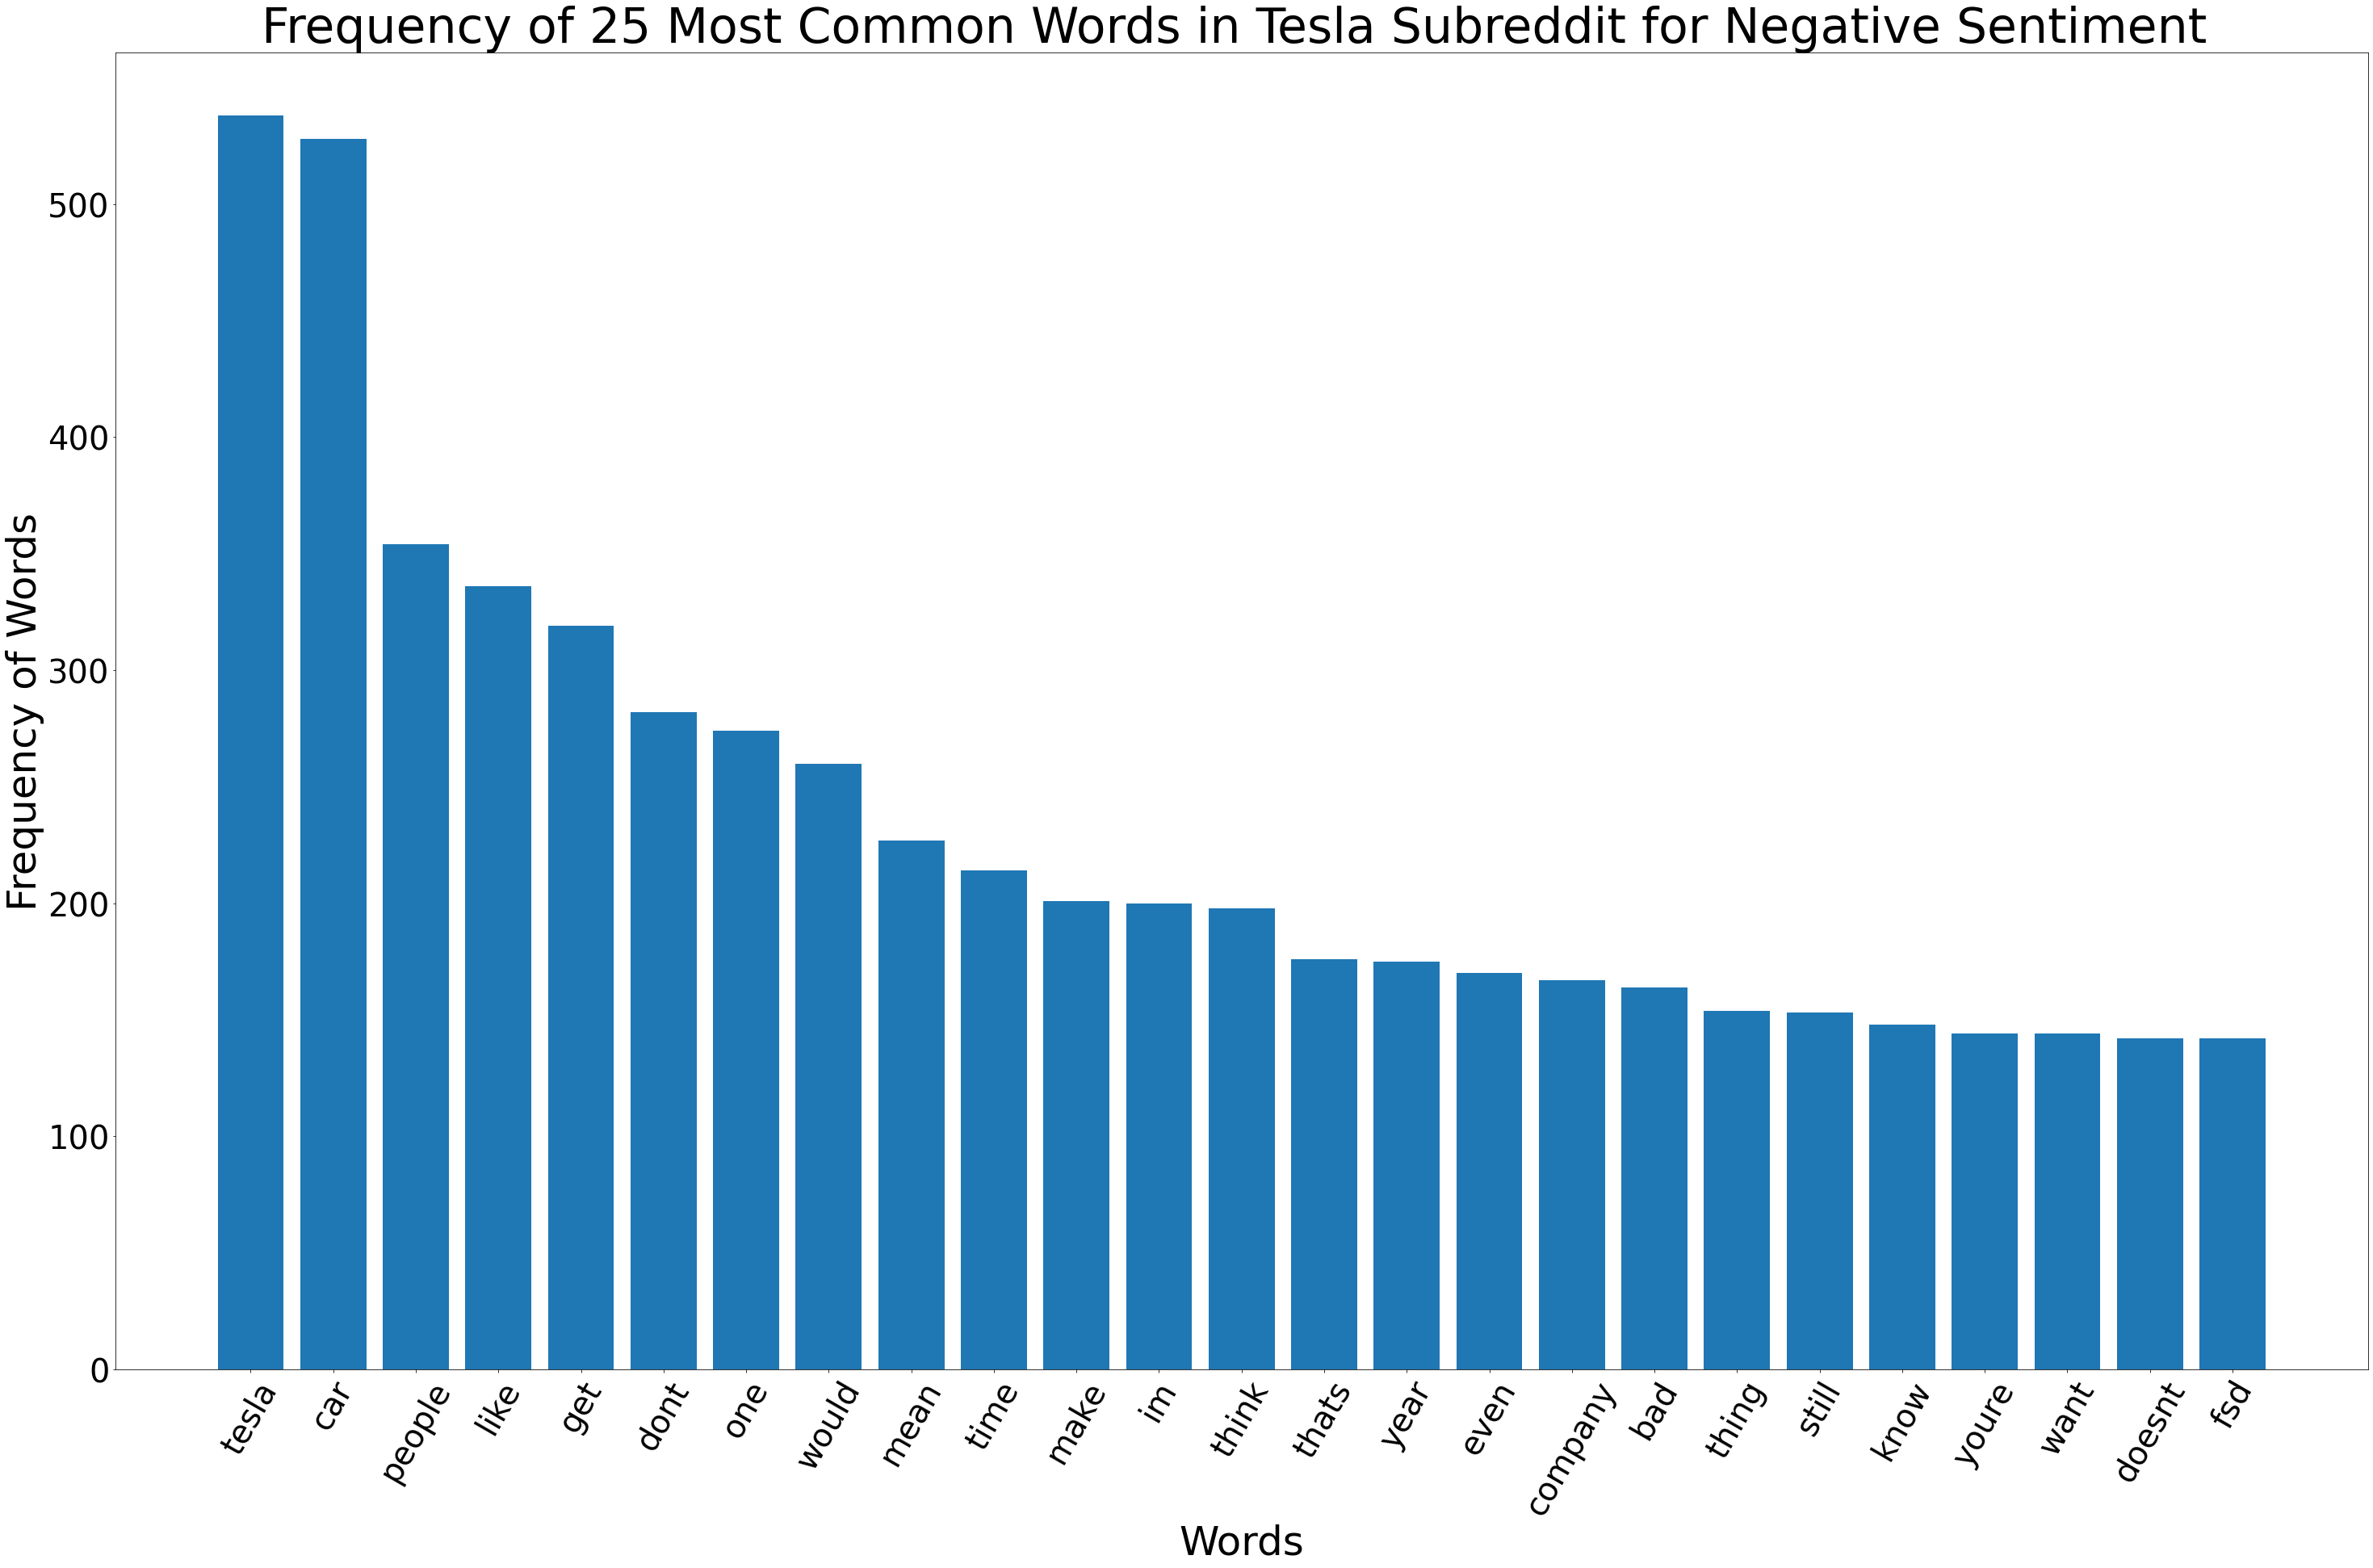

In [142]:
# Tesla Negative


words = negative_tesla_df[negative_tesla_df['year'] == 2022]['tesla_comments'].apply(word_tokenize)
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)

x ,y = zip(*mostcommon_small)


plt.figure(figsize=(50,30))

plt.bar(x,y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Tesla Subreddit for Negative Sentiment ', fontsize=60);




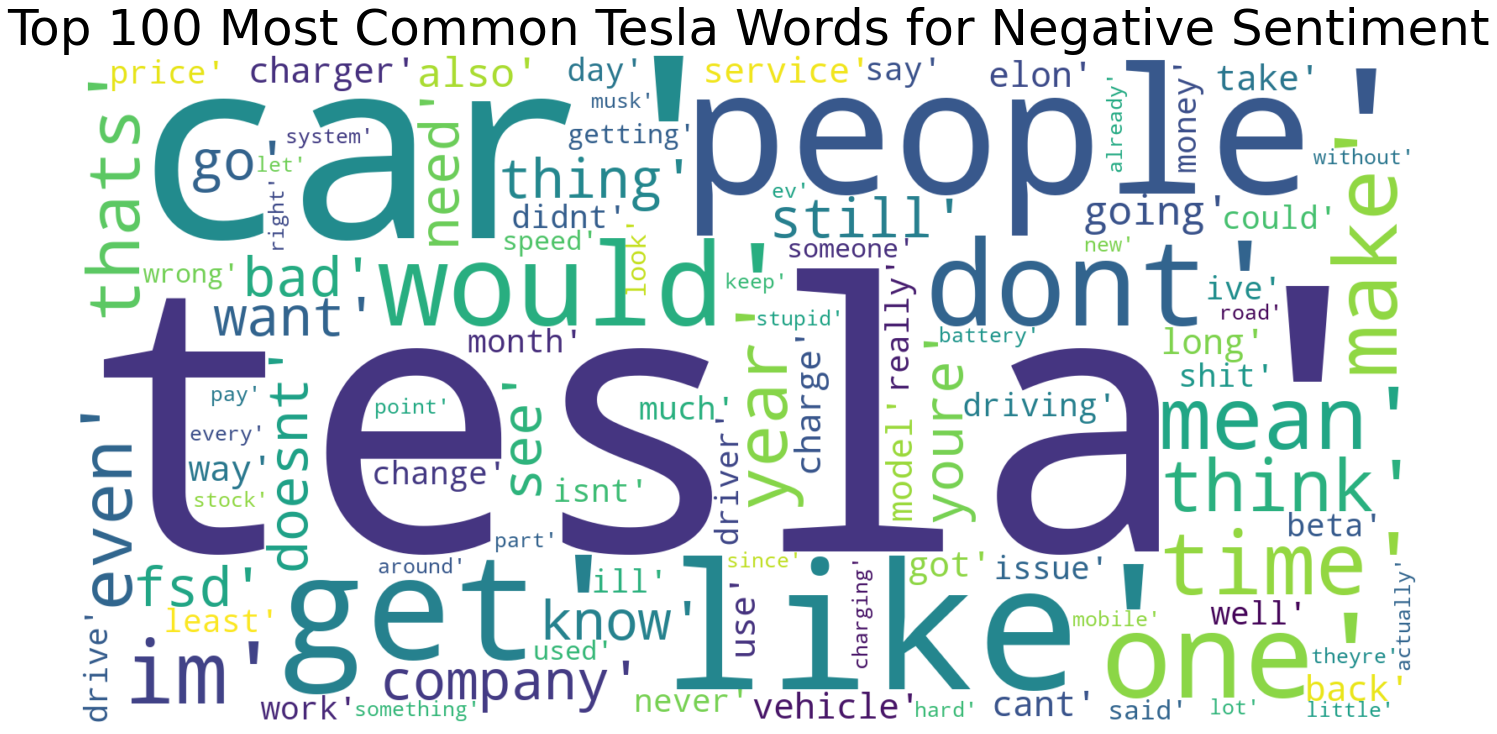

In [143]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Tesla Words for Negative Sentiment', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

### Compare Means of Sentiment with Years

In [191]:
## Compare means of sentiment with years
# This groups data sets by year and gets the mean of the sentiment scores
honda_years = honda_df.groupby('year').mean()['sentiment']


tesla_years = tesla_df.groupby('year').mean()['sentiment']

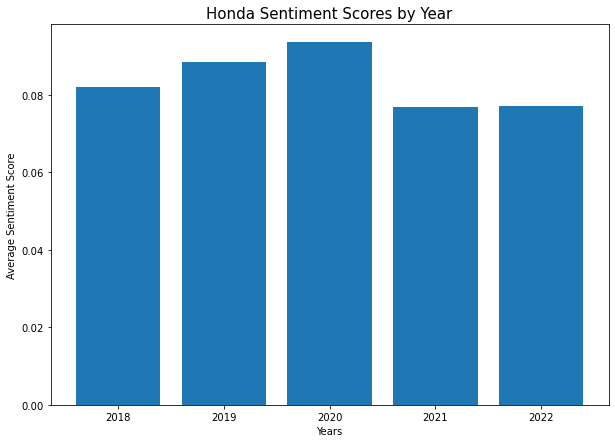

In [192]:
# Plot bar chart of the means for each year
plt.figure(figsize=(10,7))

plt.bar(honda_years.index, tesla_years.values)

plt.xlabel('Years')
plt.ylabel('Average Sentiment Score')
plt.title('Honda Sentiment Scores by Year', fontsize = 15);

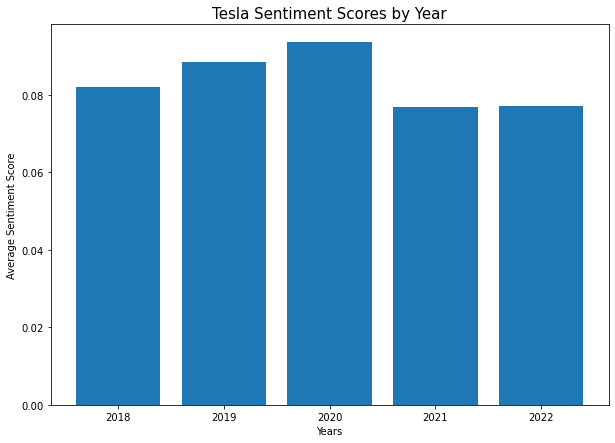

In [193]:
# Plot bar chart of the means for each year
plt.figure(figsize=(10,7))
plt.bar(tesla_years.index, tesla_years.values)

plt.xlabel('Years')
plt.ylabel('Average Sentiment Score')
plt.title('Tesla Sentiment Scores by Year',fontsize = 15);